In [48]:
# import all necessary libraries
import os
from datetime import datetime, timedelta
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import random
from osgeo import gdal
import re
from tqdm import tqdm
import shutil
import calendar

import rasterio as rio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.shutil import copy
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import Affine
from rasterio.merge import merge

import pyproj
from pyproj import Proj

from shapely.ops import transform
from shapely.geometry import Polygon

import multiprocessing
from multiprocessing.pool import ThreadPool

import time

# S2 Tiles

In [3]:
s2_tiles = gp.read_file('/scratch/user/anshulya/gis/s2-tiles.geojson')
conus = gp.read_file('/scratch/user/anshulya/gis/s_05mr24/s_05mr24.shp')

In [6]:
s2_tiles.head()

OBJECTID  Join_Count  TARGET_FID  JOIN_FID   Name  \
0         1           1        9544         3  10SDG   
1         2           1        9545         3  10SDH   
2         3           1        9546         3  10SDJ   
3         4           1        9552         3  10SEF   
4         5           1        9553         3  10SEG   

                                          FolderPath  SymbolID  AltMode  Base  \
0  S2A_OPER_GIP_TILPAR_20150622T000000_21000101T0...         0        0     0   
1  S2A_OPER_GIP_TILPAR_20150622T000000_21000101T0...         0        0     0   
2  S2A_OPER_GIP_TILPAR_20150622T000000_21000101T0...         0        0     0   
3  S2A_OPER_GIP_TILPAR_20150622T000000_21000101T0...         0        0     0   
4  S2A_OPER_GIP_TILPAR_20150622T000000_21000101T0...         0        0     0   

   Clamped  ...  Snippet                                          PopupInfo  \
0       -1  ...           TILE PROPERTIES<br><table border=0 cellpadding...   
1       -1  ...           TILE PROPERTIES<br><table border=0 cellpadding...   
2       -1  ...           TILE PROPERTIES<br><table border=0 cellpadding...   
3       -1  ...           TILE PROPERTIES<br><table border=0 cellpadding...   
4       -1  ...           TILE PROPERTIES<br><table border=0 cellpadding...   

  STATE      NAME_1 FIPS        LON       LAT  Shape_Length  Shape_Area  \
0    CA  California   06 -119.60818  37.24537      4.462236    1.228577   
1    CA  California   06 -119.60818  37.24537      4.492413    1.243465   
2    CA  California   06 -119.60818  37.24537      4.523982    1.259036   
3    CA  California   06 -119.60818  37.24537      4.433333    1.214312   
4    CA  California   06 -119.60818  37.24537      4.462166    1.228539   

                                            geometry  
0  POLYGON ((-124.13853 37.94208, -124.12363 36.9...  
1  POLYGON ((-124.15275 38.84331, -124.13717 37.8...  
2  POLYGON ((-124.16762 39.74440, -124.15133 38.7...  
3  POLYGON ((-123.00022 37.04658, -123.00022 36.0...  
4  POLYGON ((-123.00023 37.94759, -123.00022 36.9...  

[5 rows x 21 columns]

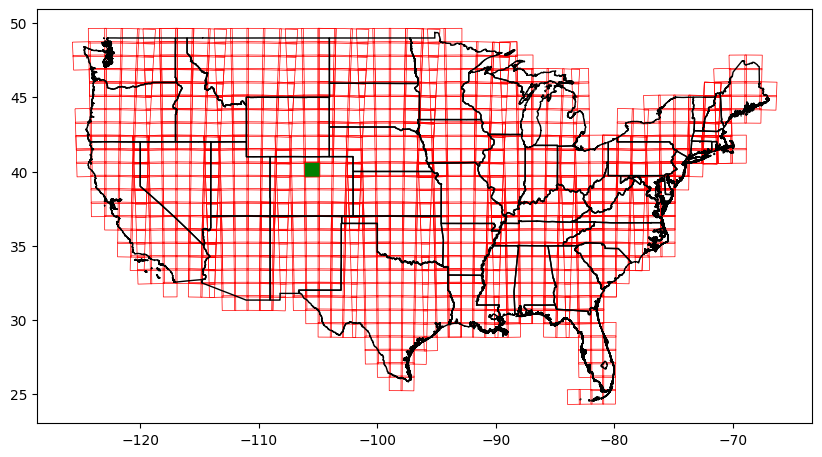

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
s2_tiles.plot(ax = ax, facecolor='none', ec = 'r', linewidth=0.5)
s2_tiles[s2_tiles['Name']=='13TDE'].plot(ax = ax, facecolor='green', ec = 'r', linewidth=0.5)
conus.plot(ax = ax, facecolor='none', ec = 'k')
plt.show()

# Download Tiles

In [9]:
link = "https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T11SQA.2021221T181517.v2.0/HLS.L30.T11SQA.2021221T181517.v2.0.B05.tif"
cmd = "python /scratch/user/anshulya/DAACDataDownload.py -dir /scratch/user/anshulya/hls_data -f {}".format(link)
os.system(cmd)

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: hls_data/HLS.L30.T11SQA.2021221T181517.v2.0.B05.tif


0

In [70]:
def get_search_params(date_str, lp_links, fieldShape):
  lp_search = [l['href'] for l in lp_links if l['rel'] == 'search'][0]    # Define the search endpoint

  # Set up a dictionary that will be used to POST requests to the search endpoint
  params = {}

  # default limit is 10, maximum limit is 250
  params['limit'] = 250

  # Defined from ROI bounds
  bbox = f'{fieldShape.bounds[0]},{fieldShape.bounds[1]},{fieldShape.bounds[2]},{fieldShape.bounds[3]}'
  params['bbox'] = bbox

  # Define start time period / end time period
  date_time = date_str + "T00:00:00Z/" + date_str + "T23:59:59Z"
  params['datetime'] = date_time

  s30_id = "HLSS30.v2.0"
  l30_id = "HLSL30.v2.0"
  params["collections"] = [s30_id, l30_id]
  # params["collections"] = [l30_id]

  return params

In [71]:
def download_unmerged_rasters(tile, day, year_start, lp_links, fieldShape):
  # Define bands to be downloaded
  l30_bands = ['B01', 'B03', 'B05', 'B06', 'B04', 'Fmask', 'B07',
        'B10', 'B02', 'B11','SAA','SZA']
  s30_bands = ['B10', 'B07', 'B09', 'B04', 'B03', 'B11', 'B06',
        'B12','B02', 'B8A', 'B08', 'B01', 'Fmask','B05','SAA','SZA']

  # Define parameters for the day
  date = year_start + timedelta(days=day)
  params = get_search_params(date.strftime('%Y-%m-%d'), lp_links, fieldShape)
  lp_search = [l['href'] for l in lp_links if l['rel'] == 'search'][0]

  s30_urls = []
  l30_urls = []

  # Search for the HLSS30 and HLSL30 items of interest:
  hls_items = r.post(lp_search, json=params).json()['features']    # Send POST request with S30 and L30 collections included
  if len(hls_items)>0:
    s_idx = []
    l_idx = []

    # find out the indices of hls_items which are from S30 and L30
    for i in range(len(hls_items)):
      h = hls_items[i]
      if h['id'].split('.')[1] == 'S30':
        s_idx.append(i)
      elif h['id'].split('.')[1] == 'L30':
        l_idx.append(i)
      else:
        continue

    # S30 rasters
    for b in s30_bands:
      for i in s_idx:
        h = hls_items[i]
        link = h['assets'][b]['href']
        if tile in link:
          s30_urls.append(link)

    # L30 rasters
    for b in l30_bands:
      for i in l_idx:
        h = hls_items[i]
        link = h['assets'][b]['href']
        if tile in link:
          l30_urls.append(link)
  else:
    print(f'data not available for day {day}')
    return

  if s30_urls:
    print('Sentinel-2 data available')

  for url in tqdm(s30_urls):
    save_path = os.path.join('/scratch/user/anshulya/',tile,'unmerged_rasters', url.split('/')[-1].split('.')[3][:7], 'S30')
    if os.path.exists(os.path.join(save_path, url.split('/')[-1])):
      continue
    cmd = f"python /scratch/user/anshulya/DAACDataDownload.py -dir {save_path} -f {url}"
    os.system(cmd)

  if l30_urls:
    print('Landsat data available')

  for url in tqdm(l30_urls):
    save_path = os.path.join('/scratch/user/anshulya/',tile,'unmerged_rasters', url.split('/')[-1].split('.')[3][:7], 'L30')
    if os.path.exists(os.path.join(save_path, url.split('/')[-1])):
      continue
    cmd = f"python /scratch/user/anshulya/DAACDataDownload.py -dir {save_path} -f {url}"
    os.system(cmd)

  # # Create an empty dataframe for each day
  # column_names = ['id', 'tile', 'cloud_cover', 'satellite', 'no_value']
  # df = pd.DataFrame(columns=column_names)

  # for i, h in enumerate(hls_items):
  #   df.loc[i,'id'] = h['id']
  #   df.loc[i,'tile'] = h['id'].split('.')[2]
  #   df.loc[i,'cloud_cover'] = int(h['properties']['eo:cloud_cover'])
  #   df.loc[i,'satellite'] = h['collection']

  #   if h['collection'] == 'HLSS30.v2.0':
  #     save_path = os.path.join(tile,'unmerged_rasters', url.split('/')[-1].split('.')[3][:7], 'S30')
  #   elif h['collection'] == 'HLSL30.v2.0':
  #     save_path = os.path.join(tile,'unmerged_rasters', url.split('/')[-1].split('.')[3][:7], 'L30')
  #   else:
  #     continue

  #   ras = rio.open(os.path.join(save_path,h['assets']['B01']['href'].split('/')[-1]))
  #   ras_data = ras.read(1)
  #   df.loc[i,'no_value'] = ras_data[ras_data==ras.meta['nodata']].shape[0]/ras_data.flatten().shape[0]
  #   ras.close()

  # head, tail = os.path.split(save_path)

  # print('Saving dataframe...')
  # df.to_csv(os.path.join(head,'tile_metadata.csv'))

  
  head, tail = os.path.split(save_path)  
  print("Unmerged rasters downloaded!!! Available at {}".format(head))
  print("------------------------------------------------------------------------------------")

  return head

In [72]:
## Reproject downloaded rasters
def project_hls_latlon(hls, jrc, filename = 'hls_proj.tif'):
  projTIF = filename
  transform, width, height = calculate_default_transform(
      hls.crs, jrc.crs, hls.width, hls.height, *hls.bounds)
  kwargs = hls.meta.copy()
  kwargs.update({
      'crs': jrc.crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rio.open(projTIF, 'w', **kwargs) as dst:
      for i in range(1, hls.count + 1):
          reproject(
              source=rio.band(hls, i),
              destination=rio.band(dst, i),
              src_transform=hls.transform,
              src_crs=hls.crs,
              dst_transform=transform,
              dst_crs=jrc.crs,
              resampling=Resampling.nearest)
  return projTIF

def reproject_unmerged_rasters(save_path):
  print('start of reprojections')
  for filename in tqdm(os.listdir(save_path)):
    if filename == 'tile_metadata.csv':
      continue
    if os.path.isfile(os.path.join(save_path, filename)):
      jrc = rio.open('/scratch/user/anshulya/383_LAKE_MEAD.tif')
      hls = rio.open(os.path.join(save_path, filename))
      project_hls_latlon(hls, jrc, os.path.join(save_path, filename))

In [73]:
def getFeatures(gdf):
  """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
  import json
  return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [74]:
def process_hls_rasters(tile, day, year_start, lp_links, fieldShape):
  print(os.path.join('/scratch/user/anshulya/',tile,'unmerged_rasters',str(year_start.year)+str(day+1).zfill(3)))
  retries = 0
  max_retries = 3
  while retries < max_retries:
    try:
      save_path = download_unmerged_rasters(tile, day, year_start, lp_links, fieldShape)

      if save_path == None:
        return


      if os.path.isdir(os.path.join(save_path,'L30')):
        flag1 = 1
        reproject_unmerged_rasters(os.path.join(save_path,'L30'))
      else:
        flag1 = 0

      if os.path.isdir(os.path.join(save_path,'S30')):
        flag2 = 1
        reproject_unmerged_rasters(os.path.join(save_path,'S30'))
      else:
        flag2 = 0

      return
    except Exception as e:
      print(f"Error downloading {day}: {e}. Retrying...")
      retries += 1
      time.sleep(5)  # Optional: wait for 5 seconds before retrying
  else:
    print(f"Failed to download {day} after {max_retries} attempts.")

In [75]:
def s2_tile_function(tile, start_date, end_date):
	## Get reservoir shapefile and geometry
  s2_tiles = gp.read_file('/scratch/user/anshulya/gis/s2-tiles.geojson')
  fieldShape = s2_tiles.loc[s2_tiles['Name']==tile,'geometry'].values[0]

	## CMR-STAC setup begins here

	# Set Up Working Environment
  inDir = os.getcwd()
  os.chdir(inDir)

  stac = 'https://cmr.earthdata.nasa.gov/stac/' # CMR-STAC API Endpoint
  stac_response = r.get(stac).json()            # Call the STAC API endpoint
  for s in stac_response: print(s)

  print(f"You are now using the {stac_response['id']} API (STAC Version: {stac_response['stac_version']}). {stac_response['description']}")
  print(f"There are {len(stac_response['links'])} STAC catalogs available in CMR.")

  stac_lp = [s for s in stac_response['links'] if 'LP' in s['title']]  # Search for only LP-specific catalogs

  # LPCLOUD is the STAC catalog we will be using and exploring today
  lp_cloud = r.get([s for s in stac_lp if s['title'] == 'LPCLOUD'][0]['href']).json()
  lp_links = lp_cloud['links']

  # Go to the next LPCLOUD page which has HLS data
  lp_ = [l['href'] for l in lp_links if l['rel'] == 'next']
  lp_cloud = r.get(f"{lp_[0]}").json()

  for l in lp_cloud: print(f"{l}: {lp_cloud[l]}")

  lp_links = lp_cloud['links']
  for l in lp_links:
    try:
      print(f"{l['href']} is the {l['title']}")
    except:
      print(f"{l['href']}")
  ## CMR-STAC setup ends here

  year_start = datetime(start_date.year,1,1)
  day1 = start_date - year_start
  day2 = end_date - year_start
  day1 = day1.days
  day2 = day2.days
  print(day1, day2)

  ## Multiprocessing setup
  num_cores = 20
  print(num_cores)

  num_chunks = (day2 - day1) // num_cores

  for i in range(num_chunks):
    t1 = datetime.now()
    chunk = range(day1, day2)[i*num_cores : (i+1)*num_cores]
    with multiprocessing.Pool(processes=len(chunk)) as pool:
      results = [pool.apply_async(process_hls_rasters, (tile, day, year_start, lp_links, fieldShape)) for day in chunk]

      # Wait for all processes to complete
      pool.close()
      pool.join()

      # Check for exceptions in the download process
      for result in results:
        result.get()


    t2 = datetime.now()
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print('URL CHUNK DONE!!!!! {}'.format(t2-t1))
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

  remaining_days = range(day1, day2)[num_chunks * num_cores :]
  if remaining_days:
    with multiprocessing.Pool(processes=len(remaining_days)) as pool:
      results = [pool.apply_async(process_hls_rasters, (tile, day, year_start, lp_links, fieldShape)) for day in remaining_days]

      # Wait for all processes to complete
      pool.close()
      pool.join()

      # Check for exceptions in the download process
      for result in results:
        result.get()

    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print('FULL PROCESSING DONE!!!!!')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

In [ ]:
s2_tile_function('13TDE' , datetime(2021,1,1), datetime(2021,12,31))

id
title
stac_version
type
description
links
You are now using the stac API (STAC Version: 1.0.0). This is the landing page for CMR-STAC. Each provider link contains a STAC endpoint.
There are 61 STAC catalogs available in CMR.
id: LPCLOUD
title: LPCLOUD
description: Root catalog for LPCLOUD
type: Catalog
stac_version: 1.0.0
links: [{'rel': 'self', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 'title': 'Provider catalog', 'type': 'application/json'}, {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/', 'title': 'Root catalog', 'type': 'application/json'}, {'rel': 'collections', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections', 'title': 'Provider Collections', 'type': 'application/json'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item Search', 'type': 'application/geo+json', 'method': 'GET'}, {'rel': 'search', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search', 'title': 'Provider Item

  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 3
data not available for day 8
data not available for day 14
data not available for day 11
data not available for day 13
Sentinel-2 data availableSentinel-2 data available



  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available

0it [00:00, ?it/s]/16 [00:00<?, ?it/s]

Landsat data available

  0%|          | 0/16 [00:00<?, ?it/s]

0it [00:00, ?it/s]/12 [00:00<?, ?it/s]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/late

Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

data not available for day 6
data not available for day 19


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Sentinel-2 data available
Sentinel-2 data available

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B10.tif


  6%|▋         | 1/16 [00:05<01:15,  5.01s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.B01.tif


  6%|▋         | 1/16 [00:05<01:15,  5.06s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.B01.tif


  8%|▊         | 1/12 [00:04<00:48,  4.38s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B10.tif


  8%|▊         | 1/12 [00:04<00:44,  4.00s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B07.tif


 12%|█▎        | 2/16 [00:09<01:04,  4.59s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B07.tif


 17%|█▋        | 2/12 [00:08<00:44,  4.47s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B07.tif


 12%|█▎        | 2/16 [00:08<00:59,  4.25s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B07.tif


 12%|█▎        | 2/16 [00:10<01:15,  5.38s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 2/12 [00:10<00:52,  5.24s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B09.tif


 19%|█▉        | 3/16 [00:15<01:06,  5.08s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B09.tif


 19%|█▉        | 3/16 [00:13<00:59,  4.61s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.B05.tif


 25%|██▌       | 3/12 [00:15<00:45,  5.09s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B04.tif


 33%|███▎      | 4/12 [00:18<00:37,  4.64s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:19<00:59,  4.96s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B04.tif


 25%|██▌       | 4/16 [00:20<01:02,  5.18s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B04.tif


 31%|███▏      | 5/16 [00:20<00:42,  3.91s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B03.tif


 31%|███▏      | 5/16 [00:20<00:44,  4.00s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B03.tif


 42%|████▏     | 5/12 [00:24<00:34,  4.95s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B03.tif


 50%|█████     | 6/12 [00:24<00:23,  3.90s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B03.tif


 31%|███▏      | 5/16 [00:25<00:57,  5.19s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.Fmask.tif


 50%|█████     | 6/12 [00:29<00:29,  4.84s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [00:30<00:39,  4.39s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B11.tif


 38%|███▊      | 6/16 [00:31<00:52,  5.27s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 7/12 [00:34<00:24,  4.96s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [00:35<00:45,  5.08s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B12.tif


 83%|████████▎ | 10/12 [00:38<00:07,  3.54s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B12.tif


 50%|█████     | 8/16 [00:40<00:39,  4.88s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.B02.tif


 50%|█████     | 8/16 [00:39<00:39,  4.97s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:43<00:32,  4.70s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B02.tif


 62%|██████▎   | 10/16 [00:43<00:24,  4.02s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:46<00:20,  4.06s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021017
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021017/L30/HLS.L30.T13TDE.2021017T174948.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:45<00:20,  4.01s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B8A.tif


 92%|█████████▏| 11/12 [00:46<00:04,  4.09s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B01.tif


 75%|███████▌  | 12/16 [00:49<00:15,  3.92s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:48<00:20,  4.10s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B8A.tif


 62%|██████▎   | 10/16 [00:49<00:29,  4.85s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:49<00:15,  3.77s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021019
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021019/L30/HLS.L30.T13TDE.2021019T173726.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:52<00:22,  4.43s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.SAA.tif


 81%|████████▏ | 13/16 [00:53<00:11,  4.00s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.Fmask.tif


 75%|███████▌  | 12/16 [00:52<00:16,  4.15s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.Fmask.tif


 69%|██████▉   | 11/16 [00:54<00:23,  4.73s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:54<00:24,  4.83s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021010/L30/HLS.L30.T13TDE.2021010T174341.v2.0.SZA.tif


100%|██████████| 12/12 [00:55<00:00,  4.66s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021010
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:56<00:07,  3.75s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.SAA.tif


 88%|████████▊ | 14/16 [00:59<00:07,  3.82s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [01:02<00:13,  4.38s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021018

 88%|████████▊ | 14/16 [01:03<00:08,  4.12s/it]


------------------------------------------------------------------------------------
start of reprojections


100%|██████████| 16/16 [01:04<00:00,  4.03s/it]
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021008
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021018/S30/HLS.S30.T13TDE.2021018T174651.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021008/S30/HLS.S30.T13TDE.2021008T174721.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [01:02<00:03,  3.71s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/S30/HLS.S30.T13TDE.2021003T174729.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.B05.tif


 88%|████████▊ | 14/16 [01:05<00:08,  4.18s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021013
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [01:07<00:03,  3.90s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021013/S30/HLS.S30.T13TDE.2021013T174709.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.B01.tif


 94%|█████████▍| 15/16 [01:09<00:03,  3.92s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.SAA.tif


 94%|█████████▍| 15/16 [01:09<00:04,  4.09s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:10<00:00,  3.76s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021006/S30/HLS.S30.T13TDE.2021006T175729.v2.0.SZA.tif



0it [00:00, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.ht

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021006
------------------------------------------------------------------------------------

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

  8%|▊         | 1/12 [00:24<04:27, 24.33s/it]

start of reprojections

  6%|▋         | 1/16 [00:07<01:52,  7.50s/it]

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021011/S30/HLS.S30.T13TDE.2021011T175721.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021016/S30/HLS.S30.T13TDE.2021016T175659.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.B03.tif




100%|██████████| 16/16 [01:14<00:00,  4.34s/it]

100%|██████████| 16/16 [01:14<00:00,  4.68s/it]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021016Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021011Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/S30/HLS.S30.T13TDE.2021001T175741.v2.0.SZA.tif



 12%|█▎        | 2/16 [00:10<01:08,  4.86s/it]

------------------------------------------------------------------------------------Landsat data available------------------------------------------------------------------------------------




  0%|          | 0/12 [00:00<?, ?it/s]

start of reprojectionsstart of reprojections



  6%|▋         | 1/16 [00:04<01:10,  4.73s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.B01.tif


 25%|██▌       | 4/16 [00:13<00:40,  3.38s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.B05.tif


 25%|██▌       | 4/16 [00:18<00:51,  4.26s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.B03.tif


 33%|███▎      | 4/12 [00:22<00:48,  6.03s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.B06.tif


 38%|███▊      | 6/16 [00:22<00:38,  3.83s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.B05.tif


 42%|████▏     | 5/12 [00:28<00:42,  6.00s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.B04.tif


 58%|█████▊    | 7/12 [00:43<00:23,  4.75s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 67%|██████▋   | 8/12 [00:49<00:16,  4.15s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.Fmask.tif


 33%|███▎      | 4/12 [00:24<00:48,  6.10s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.B06.tif


 56%|█████▋    | 9/16 [00:34<00:28,  4.09s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:38<00:29,  4.21s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.B04.tif


 58%|█████▊    | 7/12 [00:40<00:30,  6.16s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.B07.tif


 44%|████▍     | 7/16 [00:36<00:47,  5.24s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.Fmask.tif


 67%|██████▋   | 8/12 [00:47<00:25,  6.36s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.B10.tif


 75%|███████▌  | 12/16 [00:50<00:16,  4.03s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [01:03<00:00,  4.21s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.B07.tif


 56%|█████▋    | 9/16 [00:47<00:38,  5.46s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.B02.tif


 88%|████████▊ | 14/16 [00:53<00:07,  3.62s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:56<00:06,  3.42s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 10/12 [01:00<00:12,  6.24s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 92%|█████████▏| 11/12 [01:09<00:04,  4.80s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 92%|█████████▏| 11/12 [01:05<00:06,  6.05s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.SAA.tif


 75%|███████▌  | 12/16 [00:57<00:13,  3.30s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:57<00:07,  2.51s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021003

 94%|█████████▍| 15/16 [01:01<00:01,  1.97s/it]


------------------------------------------------------------------------------------Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021003/L30/HLS.L30.T13TDE.2021003T173733.v2.0.SZA.tif

start of reprojections


 17%|█▋        | 2/12 [00:03<00:15,  1.56s/it]]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.i

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.SAA.tif


 75%|███████▌  | 9/12 [00:07<00:01,  1.55it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 10/12 [00:08<00:01,  1.63it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:01<00:07,  1.81it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [01:13<00:00,  6.12s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021001
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021001/L30/HLS.L30.T13TDE.2021001T174956.v2.0.SZA.tif


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


start of reprojections


100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:55.395337
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021038/scratch/user/anshulya/13TDE/unmerged_rasters/2021037/scratch/user/anshulya/13TDE/unmerged_rasters/2021040/scratch/user/anshulya/13TDE/unmerged_rasters/2021039/scratch/user/anshulya/13TDE/unmerged_rasters/2021036/scratch/user/anshulya/13TDE/unmerged_rasters/2021035/scratch/user/anshulya/13TDE/unmerged_rasters/2021033/scratch/user/anshulya/13TDE/unmerged_rasters/2021030/scratch/user/anshulya/13TDE/unmerged_rasters/2021032/scratch/user/anshulya/13TDE/unmerged_rasters/2021031/scratch/user/anshulya/13TDE/unmerged_rasters/2021034/scratch/user/anshulya/13TDE/unmerged_rasters/2021027/scratch/user/anshulya/13TDE/unmerged_rasters/2021026/scratch/user/anshulya/13TDE/unmerged_rasters/2021022/scratch/user/anshulya/13TDE/unmerged_rasters/2021028/scratch/user/anshulya/1

  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 31


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Error downloading 27: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 29
data not available for day 24


0it [00:00, ?it/s]


Landsat data availabledata not available for day 38


  0%|          | 0/12 [00:00<?, ?it/s]


data not available for day 33
Sentinel-2 data available
data not available for day 21data not available for day 28

  0%|          | 0/16 [00:00<?, ?it/s]



data not available for day 39Sentinel-2 data available



  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B10.tif


0it [00:00, ?it/s]/16 [00:06<01:34,  6.28s/it]
0it [00:00, ?it/s]


Error downloading 27: cannot access local variable 'save_path' where it is not associated with a value. Retrying...

  8%|▊         | 1/12 [00:06<01:12,  6.63s/it]

  6%|▋         | 1/16 [00:06<01:32,  6.18s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.B01.tif


  8%|▊         | 1/12 [00:06<01:11,  6.51s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B07.tif


 12%|█▎        | 2/16 [00:10<01:11,  5.10s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:10<01:11,  5.10s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.B03.tif


 17%|█▋        | 2/12 [00:11<00:53,  5.32s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B07.tif


 12%|█▎        | 2/16 [00:11<01:20,  5.75s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Error downloading 27: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


 19%|█▉        | 3/16 [00:12<00:52,  4.01s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B09.tif


 19%|█▉        | 3/16 [00:14<00:58,  4.51s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:14<01:01,  4.71s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 3/12 [00:15<00:44,  4.89s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B04.tif


 25%|██▌       | 4/16 [00:17<00:47,  4.00s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Failed to download 27 after 3 attempts.


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.B06.tif


 25%|██▌       | 4/16 [00:18<00:51,  4.31s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 4/12 [00:19<00:36,  4.57s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:20<00:44,  4.02s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.B04.tif


 31%|███▏      | 5/16 [00:22<00:44,  4.07s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 6/12 [00:26<00:23,  3.92s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:27<00:41,  4.14s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:26<00:41,  4.12s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B06.tif


 58%|█████▊    | 7/12 [00:30<00:20,  4.02s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.B07.tif


 50%|█████     | 8/16 [00:30<00:28,  3.50s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:34<00:25,  3.67s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 9/12 [00:35<00:10,  3.51s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:35<00:25,  3.66s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:38<00:29,  4.18s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:38<00:28,  4.10s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B02.tif


 83%|████████▎ | 10/12 [00:39<00:07,  3.68s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B8A.tif


 62%|██████▎   | 10/16 [00:39<00:22,  3.74s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B8A.tif


 92%|█████████▏| 11/12 [00:43<00:03,  3.78s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B08.tif


 62%|██████▎   | 10/16 [00:43<00:25,  4.23s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B8A.tif


 69%|██████▉   | 11/16 [00:43<00:19,  3.94s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.B11.tif


 83%|████████▎ | 10/12 [00:43<00:08,  4.30s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B08.tif


100%|██████████| 12/12 [00:47<00:00,  3.96s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021035

 75%|███████▌  | 12/16 [00:47<00:15,  3.81s/it]


------------------------------------------------------------------------------------
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021035/L30/HLS.L30.T13TDE.2021035T173725.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B01.tif
start of reprojections

 75%|███████▌  | 12/16 [00:47<00:15,  3.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:47<00:21,  4.29s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.Fmask.tif


 17%|█▋        | 2/12 [00:02<00:10,  1.03s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.Fmask.tif


100%|██████████| 12/12 [00:51<00:00,  4.30s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021026Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021026/L30/HLS.L30.T13TDE.2021026T174337.v2.0.SZA.tif

------------------------------------------------------------------------------------

 81%|████████▏ | 13/16 [00:51<00:12,  4.00s/it]


start of reprojections
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.B05.tif


 50%|█████     | 6/12 [00:06<00:07,  1.21s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.Fmask.tif


 67%|██████▋   | 8/12 [00:08<00:04,  1.08s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.B05.tif


 88%|████████▊ | 14/16 [00:55<00:08,  4.13s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.SAA.tif


 42%|████▏     | 5/12 [00:06<00:09,  1.34s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.SAA.tif


 88%|████████▊ | 14/16 [01:01<00:09,  4.63s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.B05.tif


 88%|████████▊ | 14/16 [01:01<00:09,  4.69s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.B05.tif


 50%|█████     | 6/12 [00:10<00:11,  1.99s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/S30/HLS.S30.T13TDE.2021033T174539.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [01:06<00:04,  4.74s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021038
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021038/S30/HLS.S30.T13TDE.2021038T174511.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.SAA.tif


 94%|█████████▍| 15/16 [01:07<00:04,  4.89s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021023/S30/HLS.S30.T13TDE.2021023T174629.v2.0.SZA.tif


100%|██████████| 16/16 [01:07<00:00,  4.20s/it]
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021023

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w


------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021031/S30/HLS.S30.T13TDE.2021031T175551.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021036/S30/HLS.S30.T13TDE.2021036T175529.v2.0.SZA.tif


0it [00:00, ?it/s]6/16 [01:11<00:00,  4.45s/it]

0it [00:00, ?it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021031

0it [00:00, ?it/s]

------------------------------------------------------------------------------------Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021036

start of reprojections------------------------------------------------------------------------------------



  0%|          | 0/16 [00:00<?, ?it/s]

start of reprojections


  6%|▋         | 1/16 [00:03<00:59,  3.95s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:07<00:49,  3.52s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021021/S30/HLS.S30.T13TDE.2021021T175641.v2.0.SZA.tif


0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021021
------------------------------------------------------------------------------------

 25%|██▌       | 4/16 [00:11<00:27,  2.30s/it]


start of reprojections


 31%|███▏      | 5/16 [00:13<00:25,  2.29s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:03<00:47,  3.17s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.B05.tif


 31%|███▏      | 5/16 [00:16<00:31,  2.87s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:09<00:38,  2.94s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.B06.tif


 62%|██████▎   | 10/16 [00:24<00:14,  2.40s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:14<00:30,  2.73s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.B04.tif


 75%|███████▌  | 12/16 [00:30<00:10,  2.51s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.Fmask.tif


 69%|██████▉   | 11/16 [00:35<00:15,  3.11s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:28<00:16,  2.67s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is stron

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.B07.tif


 75%|███████▌  | 12/16 [00:32<00:09,  2.47s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [00:41<00:01,  1.93s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.B10.tif


100%|██████████| 16/16 [00:37<00:00,  2.36s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.i

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021033
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021033/L30/HLS.L30.T13TDE.2021033T174947.v2.0.SZA.tif


100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


start of reprojections


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:26.046140
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021042/scratch/user/anshulya/13TDE/unmerged_rasters/2021043/scratch/user/anshulya/13TDE/unmerged_rasters/2021057/scratch/user/anshulya/13TDE/unmerged_rasters/2021058/scratch/user/anshulya/13TDE/unmerged_rasters/2021044/scratch/user/anshulya/13TDE/unmerged_rasters/2021046/scratch/user/anshulya/13TDE/unmerged_rasters/2021048/scratch/user/anshulya/13TDE/unmerged_rasters/2021049/scratch/user/anshulya/13TDE/unmerged_rasters/2021045/scratch/user/anshulya/13TDE/unmerged_rasters/2021051/scratch/user/anshulya/13TDE/unmerged_rasters/2021056/scratch/user/anshulya/13TDE/unmerged_rasters/2021052/scratch/user/anshulya/13TDE/unmerged_rasters/2021054/scratch/user/anshulya/13TDE/unmerged_rasters/2021059/scratch/user/anshulya/13TDE/unmerged_rasters/2021050/scratch/user/anshulya/1

  0%|          | 0/16 [00:00<?, ?it/s]


data not available for day 51
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


0it [00:00, ?it/s]/16 [00:00<?, ?it/s]

Sentinel-2 data available


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


0it [00:00, ?it/s]/16 [00:00<?, ?it/s]


Error downloading 47: cannot access local variable 'save_path' where it is not associated with a value. Retrying...
data not available for day 44data not available for day 58
data not available for day 43

Sentinel-2 data availabledata not available for day 49



  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 54
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

data not available for day 59
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Landsat data available


0it [00:00, ?it/s]/12 [00:00<?, ?it/s]


Landsat data available

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

data not available for day 53


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B10.tif


  6%|▋         | 1/16 [00:03<00:52,  3.51s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B10.tif


  8%|▊         | 1/12 [00:03<00:38,  3.52s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B10.tif


  6%|▋         | 1/16 [00:03<00:58,  3.92s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Error downloading 47: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:07<00:49,  3.52s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B07.tif


 12%|█▎        | 2/16 [00:07<00:54,  3.91s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.B03.tif


 12%|█▎        | 2/16 [00:07<00:57,  4.08s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B07.tif


 12%|█▎        | 2/16 [00:08<00:59,  4.27s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Error downloading 47: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


 19%|█▉        | 3/16 [00:12<00:54,  4.18s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:16<00:48,  4.04s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Failed to download 47 after 3 attempts.

 31%|███▏      | 5/16 [00:17<00:38,  3.54s/it]


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B03.tif


 25%|██▌       | 4/16 [00:17<00:52,  4.37s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.B06.tif


 33%|███▎      | 4/12 [00:16<00:32,  4.11s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B03.tif


 42%|████▏     | 5/12 [00:17<00:24,  3.45s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:20<00:45,  4.10s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 5/12 [00:20<00:29,  4.17s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.B04.tif


 50%|█████     | 6/12 [00:20<00:19,  3.31s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.Fmask.tif


 38%|███▊      | 6/16 [00:22<00:36,  3.63s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:24<00:39,  3.94s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B06.tif


 44%|████▍     | 7/16 [00:26<00:36,  4.02s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:25<00:43,  4.33s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B06.tif


 44%|████▍     | 7/16 [00:26<00:33,  3.72s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 8/16 [00:30<00:33,  4.13s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B06.tif


 58%|█████▊    | 7/12 [00:29<00:21,  4.31s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.B07.tif


 50%|█████     | 8/16 [00:30<00:30,  3.79s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [00:30<00:41,  4.60s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B12.tif


 50%|█████     | 8/16 [00:31<00:30,  3.79s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:34<00:28,  4.01s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 8/16 [00:34<00:34,  4.37s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B12.tif


 67%|██████▋   | 8/12 [00:33<00:17,  4.40s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:34<00:27,  3.89s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B02.tif


 50%|█████     | 8/16 [00:34<00:35,  4.44s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B12.tif


 56%|█████▋    | 9/16 [00:35<00:27,  3.97s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:38<00:29,  4.28s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:38<00:23,  3.93s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B8A.tif


 75%|███████▌  | 9/12 [00:38<00:13,  4.39s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.SAA.tif


 92%|█████████▏| 11/12 [00:38<00:03,  3.41s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:39<00:23,  4.00s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:42<00:19,  3.91s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [00:42<00:00,  3.52s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021049
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021049/L30/HLS.L30.T13TDE.2021049T174943.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 10/12 [00:42<00:08,  4.32s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 1/12 [00:01<00:11,  1.06s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B01.tif


 17%|█▋        | 2/12 [00:02<00:10,  1.03s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 5/12 [00:03<00:04,  1.51it/s]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B08.tif


 81%|████████▏ | 13/16 [00:48<00:10,  3.64s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.Fmask.tif


 83%|████████▎ | 10/12 [00:07<00:01,  1.44it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [00:50<00:00,  4.20s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021042
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021042/L30/HLS.L30.T13TDE.2021042T174334.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B01.tif


 92%|█████████▏| 11/12 [00:08<00:00,  1.46it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:52<00:07,  3.68s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B01.tif


 75%|███████▌  | 12/16 [00:52<00:17,  4.41s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.B05.tif


 81%|████████▏ | 13/16 [00:55<00:12,  4.26s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 3/12 [00:04<00:11,  1.29s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.Fmask.tif


 81%|████████▏ | 13/16 [00:57<00:13,  4.41s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021043Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021043/S30/HLS.S30.T13TDE.2021043T174439.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021053/S30/HLS.S30.T13TDE.2021053T174329.v2.0.SZA.tif


100%|██████████| 16/16 [01:01<00:00,  3.83s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021053


 88%|████████▊ | 14/16 [01:01<00:08,  4.42s/it]

------------------------------------------------------------------------------------
start of reprojectionsDownloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.B05.tif



/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [01:02<00:09,  4.52s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.B05.tif


 67%|██████▋   | 8/12 [00:10<00:05,  1.42s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021058/S30/HLS.S30.T13TDE.2021058T174301.v2.0.SZA.tif



/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021058
------------------------------------------------------------------------------------
start of reprojections


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:02<00:31,  2.09s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.B05.tif


 88%|████████▊ | 14/16 [01:06<00:10,  5.29s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [01:06<00:04,  4.56s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:03<00:45,  3.01s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021046/S30/HLS.S30.T13TDE.2021046T175419.v2.0.SZA.tif


0it [00:00, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021046
------------------------------------------------------------------------------------


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:09<00:00,  4.37s/it]


Landsat data availableDownloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/S30/HLS.S30.T13TDE.2021051T175351.v2.0.SZA.tif



 94%|█████████▍| 15/16 [01:10<00:05,  5.07s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:11<00:00,  4.48s/it]


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021056/S30/HLS.S30.T13TDE.2021056T175309.v2.0.SZA.tif


0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021056
------------------------------------------------------------------------------------
start of reprojections


 31%|███▏      | 5/16 [00:10<00:24,  2.25s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021041/S30/HLS.S30.T13TDE.2021041T175451.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.B01.tif


0it [00:00, ?it/s]/16 [00:12<00:26,  2.41s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021041
------------------------------------------------------------------------------------


 44%|████▍     | 7/16 [00:16<00:22,  2.45s/it]

start of reprojections


 38%|███▊      | 6/16 [00:15<00:25,  2.54s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 8/16 [00:18<00:20,  2.56s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.B03.tif


 62%|██████▎   | 10/16 [00:23<00:14,  2.44s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:26<00:12,  2.41s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.B05.tif


 81%|████████▏ | 13/16 [00:31<00:07,  2.63s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:16<00:34,  3.11s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.B06.tif


 44%|████▍     | 7/16 [00:23<00:29,  3.30s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.B04.tif


 75%|███████▌  | 12/16 [00:37<00:09,  2.30s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.Fmask.tif


 94%|█████████▍| 15/16 [00:41<00:01,  1.59s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021051
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021051/L30/HLS.L30.T13TDE.2021051T173720.v2.0.SZA.tif


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


start of reprojections


100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:36.182237
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021080/scratch/user/anshulya/13TDE/unmerged_rasters/2021078/scratch/user/anshulya/13TDE/unmerged_rasters/2021079/scratch/user/anshulya/13TDE/unmerged_rasters/2021077/scratch/user/anshulya/13TDE/unmerged_rasters/2021076/scratch/user/anshulya/13TDE/unmerged_rasters/2021075/scratch/user/anshulya/13TDE/unmerged_rasters/2021068/scratch/user/anshulya/13TDE/unmerged_rasters/2021074/scratch/user/anshulya/13TDE/unmerged_rasters/2021073/scratch/user/anshulya/13TDE/unmerged_rasters/2021064/scratch/user/anshulya/13TDE/unmerged_rasters/2021069/scratch/user/anshulya/13TDE/unmerged_rasters/2021065/scratch/user/anshulya/13TDE/unmerged_rasters/2021067/scratch/user/anshulya/13TDE/unmerged_rasters/2021072/scratch/user/anshulya/13TDE/unmerged_rasters/2021066/scratch/user/anshulya/1

  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 76data not available for day 68

data not available for day 74
data not available for day 62
data not available for day 78
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 69
data not available for day 71
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Landsat data available


0it [00:00, ?it/s]/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
0it [00:00, ?it/s]
0it [00:00, ?it/s]

data not available for day 79


0it [00:00, ?it/s]


Landsat data available


Error downloading 72: cannot access local variable 'save_path' where it is not associated with a value. Retrying...

  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]


Landsat data available


0it [00:00, ?it/s]/12 [00:00<?, ?it/s]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/late

Error downloading 75: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B10.tif


  6%|▋         | 1/16 [00:04<01:02,  4.19s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 1/12 [00:04<00:45,  4.18s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Error downloading 72: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
0it [00:00, ?it/s]/16 [00:07<00:53,  3.81s/it]
0it [00:00, ?it/s]


Error downloading 75: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B07.tif


 12%|█▎        | 2/16 [00:07<00:51,  3.66s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B07.tif


 17%|█▋        | 2/12 [00:08<00:40,  4.06s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.B05.tif


 19%|█▉        | 3/16 [00:11<00:48,  3.74s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B09.tif


 19%|█▉        | 3/16 [00:10<00:47,  3.62s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.B05.tif


 19%|█▉        | 3/16 [00:12<00:52,  4.04s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B09.tif


 25%|██▌       | 3/12 [00:12<00:35,  3.99s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Error downloading 75: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Error downloading 72: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.B06.tif


 25%|██▌       | 4/16 [00:14<00:45,  3.79s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B04.tif


 25%|██▌       | 4/16 [00:14<00:43,  3.66s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.B06.tif


 25%|██▌       | 4/16 [00:15<00:48,  4.00s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.B04.tif


 31%|███▏      | 5/16 [00:18<00:40,  3.69s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B03.tif
Failed to download 75 after 3 attempts.


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Failed to download 72 after 3 attempts.
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:20<00:46,  4.24s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B11.tif


 38%|███▊      | 6/16 [00:21<00:35,  3.52s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.Fmask.tif


 38%|███▊      | 6/16 [00:23<00:38,  3.87s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:24<00:39,  3.95s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:24<00:40,  4.07s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [00:26<00:34,  3.84s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [00:27<00:35,  3.91s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B06.tif


 50%|█████     | 8/16 [00:28<00:28,  3.52s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B12.tif


 50%|█████     | 8/16 [00:28<00:27,  3.47s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B12.tif


 75%|███████▌  | 9/12 [00:29<00:09,  3.29s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:31<00:24,  3.47s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B02.tif


 75%|███████▌  | 9/12 [00:31<00:10,  3.37s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B12.tif


 50%|█████     | 8/16 [00:32<00:31,  3.98s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B8A.tif


 56%|█████▋    | 9/16 [00:35<00:27,  3.92s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.B11.tif


 83%|████████▎ | 10/12 [00:35<00:06,  3.43s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021065
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021065/L30/HLS.L30.T13TDE.2021065T174935.v2.0.SZA.tif


 62%|██████▎   | 10/16 [00:40<00:23,  3.92s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 1/12 [00:00<00:09,  1.19it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 2/12 [00:01<00:06,  1.47it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021067
------------------------------------------------------------------------------------
start of reprojections
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021067/L30/HLS.L30.T13TDE.2021067T173736.v2.0.SZA.tif


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:43<00:15,  3.79s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advise

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B01.tif


 42%|████▏     | 5/12 [00:03<00:04,  1.40it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 1/12 [00:01<00:11,  1.02s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:44<00:21,  4.22s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 2/12 [00:02<00:12,  1.30s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B01.tif


 67%|██████▋   | 8/12 [00:07<00:04,  1.04s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.Fmask.tif


 42%|████▏     | 5/12 [00:05<00:06,  1.03it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:48<00:16,  4.20s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B01.tif


 50%|█████     | 6/12 [00:06<00:05,  1.02it/s]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.B11.tif


 75%|███████▌  | 12/16 [00:50<00:18,  4.66s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.Fmask.tif


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.i

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.B05.tif


 92%|█████████▏| 11/12 [00:10<00:00,  1.16it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.SAA.tif


 94%|█████████▍| 15/16 [00:56<00:04,  4.17s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:56<00:08,  4.19s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021074
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021074/L30/HLS.L30.T13TDE.2021074T174319.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:59<00:08,  4.41s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.B05.tif


  8%|▊         | 1/12 [00:01<00:11,  1.02s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:00<00:00,  3.78s/it]
0it [00:00, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021078
------------------------------------------------------------------------------------
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021078/S30/HLS.S30.T13TDE.2021078T174031.v2.0.SZA.tif
start of reprojections

100%|██████████| 16/16 [01:00<00:00,  3.90s/it]

  0%|          | 0/16 [00:00<?, ?it/s]3.76s/it]
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021068
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021068/S30/HLS.S30.T13TDE.2021068T174141.v2.0.SZA.tif
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 2/12 [00:02<00:10,  1.04s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021071/S30/HLS.S30.T13TDE.2021071T175131.v2.0.SZA.tif


100%|██████████| 16/16 [01:04<00:00,  4.01s/it]
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021071


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 4/12 [00:06<00:16,  2.03s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021066
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021066/S30/HLS.S30.T13TDE.2021066T175109.v2.0.SZA.tif
------------------------------------------------------------------------------------

 25%|██▌       | 4/16 [00:06<00:21,  1.77s/it]


start of reprojections


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:04<00:29,  2.12s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021061/S30/HLS.S30.T13TDE.2021061T175241.v2.0.SZA.tif


0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021061
------------------------------------------------------------------------------------
start of reprojections


100%|██████████| 16/16 [00:34<00:00,  2.18s/it]

100%|██████████| 16/16 [00:38<00:00,  2.42s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:01:51.467599
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021100/scratch/user/anshulya/13TDE/unmerged_rasters/2021099/scratch/user/anshulya/13TDE/unmerged_rasters/2021097/scratch/user/anshulya/13TDE/unmerged_rasters/2021096/scratch/user/anshulya/13TDE/unmerged_rasters/2021095/scratch/user/anshulya/13TDE/unmerged_rasters/2021098/scratch/user/anshulya/13TDE/unmerged_rasters/2021093/scratch/user/anshulya/13TDE/unmerged_rasters/2021087/scratch/user/anshulya/13TDE/unmerged_rasters/2021086/scratch/user/anshulya/13TDE/unmerged_rasters/2021090/scratch/user/anshulya/13TDE/unmerged_rasters/2021089/scratch/user/anshulya/13TDE/unmerged_rasters/2021088/scratch/user/anshulya/13TDE/unmerged_rasters/2021085/scratch/user/anshulya/13TDE/unmerged_rasters/2021092/scratch/user/anshulya/13TDE/unmerged_rasters/2021083/scratch/user/anshulya/1

0it [00:00, ?it/s]


Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

data not available for day 86
data not available for day 94
data not available for day 93

0it [00:00, ?it/s]

0it [00:00, ?it/s]

data not available for day 83


Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

data not available for day 91
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 84
data not available for day 88
Sentinel-2 data available
data not available for day 81

  0%|          | 0/16 [00:00<?, ?it/s]


Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Sentinel-2 data available


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Sentinel-2 data available

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Sentinel-2 data available


0it [00:00, ?it/s]/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B10.tif


  8%|▊         | 1/12 [00:04<00:47,  4.28s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:03<00:54,  3.64s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B10.tif


  8%|▊         | 1/12 [00:04<00:45,  4.09s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.B01.tif


  6%|▋         | 1/16 [00:04<01:09,  4.66s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:08<00:57,  4.09s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B07.tif


 12%|█▎        | 2/16 [00:08<01:01,  4.36s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B07.tif


 17%|█▋        | 2/12 [00:08<00:41,  4.17s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.B03.tif


 12%|█▎        | 2/16 [00:08<01:02,  4.44s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:09<01:05,  4.65s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B09.tif


 19%|█▉        | 3/16 [00:12<00:52,  4.06s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:15<00:47,  3.93s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 4/12 [00:16<00:31,  3.94s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:17<00:52,  4.38s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B03.tif


 31%|███▏      | 5/16 [00:22<00:48,  4.38s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B03.tif


 38%|███▊      | 6/16 [00:22<00:36,  3.63s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B11.tif


 58%|█████▊    | 7/12 [00:25<00:17,  3.42s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:25<00:41,  4.18s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [00:25<00:31,  3.51s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B12.tif


 75%|███████▌  | 9/12 [00:31<00:10,  3.35s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B12.tif


 44%|████▍     | 7/16 [00:30<00:39,  4.43s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.B10.tif


 67%|██████▋   | 8/12 [00:32<00:15,  3.94s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B12.tif


 56%|█████▋    | 9/16 [00:33<00:26,  3.72s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:33<00:26,  3.77s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 8/16 [00:33<00:33,  4.18s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B12.tif


 56%|█████▋    | 9/16 [00:33<00:25,  3.71s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B8A.tif


 92%|█████████▏| 11/12 [00:38<00:03,  3.47s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:39<00:29,  4.27s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B02.tif


 83%|████████▎ | 10/12 [00:40<00:07,  3.89s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:40<00:22,  3.81s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B8A.tif


 69%|██████▉   | 11/16 [00:40<00:17,  3.54s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [00:41<00:00,  3.49s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021097
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021097/L30/HLS.L30.T13TDE.2021097T174924.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:41<00:18,  3.69s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B08.tif


 92%|█████████▏| 11/12 [00:41<00:03,  3.62s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.SAA.tif


 17%|█▋        | 2/12 [00:01<00:07,  1.31it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.SAA.tif


 62%|██████▎   | 10/16 [00:42<00:25,  4.25s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 3/12 [00:03<00:09,  1.08s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021099
------------------------------------------------------------------------------------

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w


start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021099/L30/HLS.L30.T13TDE.2021099T173701.v2.0.SZA.tif


 42%|████▏     | 5/12 [00:05<00:07,  1.00s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:45<00:15,  3.89s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021090Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021090/L30/HLS.L30.T13TDE.2021090T174315.v2.0.SZA.tif



/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

------------------------------------------------------------------------------------
start of reprojections


 50%|█████     | 6/12 [00:06<00:06,  1.10s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.Fmask.tif


  8%|▊         | 1/12 [00:02<00:27,  2.53s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:48<00:16,  4.05s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.Fmask.tif


 81%|████████▏ | 13/16 [00:48<00:11,  3.77s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:52<00:18,  4.51s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B01.tif


 75%|███████▌  | 9/12 [00:11<00:04,  1.56s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:53<00:12,  4.23s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:56<00:13,  4.55s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [00:57<00:04,  4.15s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [00:57<00:04,  4.16s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.B05.tif


100%|██████████| 12/12 [00:17<00:00,  1.47s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021088/S30/HLS.S30.T13TDE.2021088T173921.v2.0.SZA.tif


100%|██████████| 16/16 [01:01<00:00,  4.16s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:01<00:00,  3.84s/it]
0it [00:00, ?it/s]
 42%|████▏     | 5/12 [00:13<00:17,  2.45s/it]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021088
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021093/S30/HLS.S30.T13TDE.2021093T173859.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.B05.tif



0it [00:00, ?it/s]4/16 [01:01<00:09,  4.68s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021093


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [01:02<00:04,  4.36s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021098/S30/HLS.S30.T13TDE.2021098T173901.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.SAA.tif


100%|██████████| 16/16 [01:02<00:00,  3.91s/it]
0it [00:00, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021098

 88%|████████▊ | 14/16 [01:03<00:09,  4.86s/it]


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.B05.tif
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:02<00:44,  2.94s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/S30/HLS.S30.T13TDE.2021083T173859.v2.0.SZA.tif


Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s].30s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:05<00:35,  2.52s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:08<00:00,  4.26s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/S30/HLS.S30.T13TDE.2021081T175011.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021096/S30/HLS.S30.T13TDE.2021096T174909.v2.0.SZA.tif


100%|██████████| 16/16 [01:07<00:00,  4.21s/it]



Landsat data available

0it [00:00, ?it/s]

 94%|█████████▍| 15/16 [01:08<00:04,  4.79s/it]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021096

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.SAA.tif
------------------------------------------------------------------------------------
start of reprojections


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:11<00:00,  4.46s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021086/S30/HLS.S30.T13TDE.2021086T174909.v2.0.SZA.tif



 19%|█▉        | 3/16 [00:09<00:39,  3.01s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021086
------------------------------------------------------------------------------------

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  8%|▊         | 1/12 [00:04<00:49,  4.51s/it]

start of reprojections

  6%|▋         | 1/16 [00:04<01:00,  4.02s/it]


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.B01.tif


100%|██████████| 16/16 [01:13<00:00,  4.57s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021091/S30/HLS.S30.T13TDE.2021091T174901.v2.0.SZA.tif



0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021091

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



------------------------------------------------------------------------------------
start of reprojections

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


 67%|██████▋   | 8/12 [00:27<00:15,  4.00s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 2/12 [00:10<00:51,  5.11s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.B03.tif


 38%|███▊      | 6/16 [00:18<00:31,  3.19s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.B05.tif


 19%|█▉        | 3/16 [00:14<01:05,  5.03s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 3/12 [00:15<00:48,  5.39s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.B05.tif


 50%|█████     | 8/16 [00:24<00:25,  3.20s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.B06.tif


 33%|███▎      | 4/12 [00:23<00:47,  5.94s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.B06.tif


 62%|██████▎   | 10/16 [00:30<00:18,  3.14s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.B04.tif


 42%|████▏     | 5/12 [00:29<00:42,  6.07s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.B04.tif


 75%|███████▌  | 12/16 [00:36<00:12,  3.05s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.Fmask.tif


 44%|████▍     | 7/16 [00:35<00:45,  5.02s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.B07.tif


 58%|█████▊    | 7/12 [00:41<00:30,  6.16s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.B07.tif


 56%|█████▋    | 9/16 [00:41<00:28,  4.10s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [00:47<00:00,  2.99s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.B10.tif


 62%|██████▎   | 10/16 [00:43<00:19,  3.20s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:48<00:06,  2.12s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.B02.tif


 75%|███████▌  | 9/12 [00:53<00:18,  6.18s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.B02.tif


 81%|████████▏ | 13/16 [00:48<00:06,  2.29s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.SAA.tif


 92%|█████████▏| 11/12 [01:02<00:05,  5.08s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021081
------------------------------------------------------------------------------------
start of reprojections


100%|██████████| 12/12 [01:05<00:00,  5.46s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021083Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021081/L30/HLS.L30.T13TDE.2021081T174928.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021083/L30/HLS.L30.T13TDE.2021083T173706.v2.0.SZA.tif

------------------------------------------------------------------------------------
start of reprojections


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


start of reprojections


100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


start of reprojections


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:42.055466
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021119/scratch/user/anshulya/13TDE/unmerged_rasters/2021120/scratch/user/anshulya/13TDE/unmerged_rasters/2021117/scratch/user/anshulya/13TDE/unmerged_rasters/2021118/scratch/user/anshulya/13TDE/unmerged_rasters/2021112/scratch/user/anshulya/13TDE/unmerged_rasters/2021116/scratch/user/anshulya/13TDE/unmerged_rasters/2021109/scratch/user/anshulya/13TDE/unmerged_rasters/2021115/scratch/user/anshulya/13TDE/unmerged_rasters/2021114/scratch/user/anshulya/13TDE/unmerged_rasters/2021113/scratch/user/anshulya/13TDE/unmerged_rasters/2021111/scratch/user/anshulya/13TDE/unmerged_rasters/2021106/scratch/user/anshulya/13TDE/unmerged_rasters/2021104/scratch/user/anshulya/13TDE/unmerged_rasters/2021107/scratch/user/anshulya/13TDE/unmerged_rasters/2021108/scratch/user/anshulya/1

  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 111
data not available for day 101
data not available for day 108


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


data not available for day 113
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 118data not available for day 106Sentinel-2 data available

data not available for day 103
data not available for day 119



  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
0it [00:00, ?it/s]

Sentinel-2 data available

data not available for day 109data not available for day 116
Landsat data available

Sentinel-2 data available



  0%|          | 0/12 [00:00<?, ?it/s]

Sentinel-2 data available

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:03<00:53,  3.57s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B10.tif


  6%|▋         | 1/16 [00:04<01:00,  4.05s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B10.tif


  6%|▋         | 1/16 [00:04<01:03,  4.24s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B07.tif


 12%|█▎        | 2/16 [00:07<00:53,  3.83s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B07.tif


 12%|█▎        | 2/16 [00:07<00:53,  3.79s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B09.tif


 19%|█▉        | 3/16 [00:10<00:47,  3.64s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:11<00:49,  3.79s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:15<00:48,  4.03s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B04.tif


 25%|██▌       | 4/16 [00:15<00:46,  3.90s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:16<00:49,  4.16s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B03.tif


 31%|███▏      | 5/16 [00:18<00:39,  3.63s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:19<00:45,  4.10s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B03.tif


 31%|███▏      | 5/16 [00:20<00:44,  4.05s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B11.tif


 38%|███▊      | 6/16 [00:22<00:36,  3.67s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.Fmask.tif


 38%|███▊      | 6/16 [00:23<00:40,  4.03s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:23<00:39,  3.97s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B11.tif


 38%|███▊      | 6/16 [00:23<00:40,  4.08s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B06.tif


 44%|████▍     | 7/16 [00:25<00:32,  3.58s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B06.tif


 44%|████▍     | 7/16 [00:26<00:35,  3.91s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B06.tif


 44%|████▍     | 7/16 [00:27<00:36,  4.01s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B06.tif


 50%|█████     | 8/16 [00:28<00:28,  3.50s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B12.tif


 50%|█████     | 8/16 [00:31<00:31,  3.98s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B12.tif


 56%|█████▋    | 9/16 [00:31<00:23,  3.42s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B02.tif


 50%|█████     | 8/16 [00:32<00:31,  3.96s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:33<00:25,  3.68s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:35<00:27,  3.97s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:35<00:20,  3.46s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:37<00:22,  3.72s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:39<00:17,  3.51s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:39<00:24,  4.00s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:42<00:19,  3.83s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:43<00:19,  3.98s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:43<00:19,  3.81s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021115
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021115/L30/HLS.L30.T13TDE.2021115T173653.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:44<00:14,  3.61s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:44<00:14,  3.60s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B01.tif


  8%|▊         | 1/12 [00:00<00:08,  1.29it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:47<00:15,  3.95s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:46<00:15,  3.82s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B01.tif


 75%|███████▌  | 12/16 [00:47<00:15,  3.90s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:50<00:07,  3.82s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.Fmask.tif


 81%|████████▏ | 13/16 [00:50<00:11,  3.75s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.Fmask.tif


 81%|████████▏ | 13/16 [00:51<00:11,  3.95s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.B05.tif


 94%|█████████▍| 15/16 [00:54<00:03,  3.90s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.SAA.tif


 92%|█████████▏| 11/12 [00:09<00:00,  1.23it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [00:55<00:03,  3.93s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.SAA.tif


 88%|████████▊ | 14/16 [00:55<00:08,  4.10s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.B05.tif


 88%|████████▊ | 14/16 [00:55<00:08,  4.08s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021103

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w


------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021103/S30/HLS.S30.T13TDE.2021103T173859.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021118


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


------------------------------------------------------------------------------------
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021118/S30/HLS.S30.T13TDE.2021118T173901.v2.0.SZA.tif
start of reprojections


 94%|█████████▍| 15/16 [01:00<00:04,  4.16s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.SAA.tif


  6%|▋         | 1/16 [00:01<00:16,  1.10s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Landsat data available

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021108Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021108/S30/HLS.S30.T13TDE.2021108T173901.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/S30/HLS.S30.T13TDE.2021113T173859.v2.0.SZA.tif

------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021116/S30/HLS.S30.T13TDE.2021116T174859.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021101/S30/HLS.S30.T13TDE.2021101T174901.v2.0.SZA.tif



100%|██████████| 16/16 [01:03<00:00,  3.97s/it]


0it [00:00, ?it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021116Landsat data available

0it [00:00, ?it/s]



Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/S30/HLS.S30.T13TDE.2021106T174909.v2.0.SZA.tif


------------------------------------------------------------------------------------

  0%|          | 0/12 [00:00<?, ?it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021101

100%|██████████| 16/16 [01:03<00:00,  4.19s/it]

 19%|█▉        | 3/16 [00:04<00:19,  1.50s/it]

100%|██████████| 16/16 [01:03<00:00,  3.98s/it]

start of reprojections------------------------------------------------------------------------------------

0it [00:00, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021111/S30/HLS.S30.T13TDE.2021111T174901.v2.0.SZA.tif


  0%|          | 0/16 [00:00<?, ?it/s]

start of reprojections

0it [00:00, ?it/s]


  0%|          | 0/16 [00:00<?, ?it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021111
------------------------------------------------------------------------------------

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



start of reprojections


 31%|███▏      | 5/16 [00:06<00:13,  1.27s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.B01.tif


  6%|▋         | 1/16 [00:03<00:54,  3.63s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:05<00:40,  2.86s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:04<01:11,  4.74s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:08<00:36,  2.81s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.B03.tif


 50%|█████     | 8/16 [00:18<00:21,  2.63s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:13<00:58,  4.46s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 3/12 [00:15<00:48,  5.40s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.B05.tif


 62%|██████▎   | 10/16 [00:20<00:16,  2.70s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:14<00:42,  3.51s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.B05.tif


 25%|██▌       | 3/12 [00:19<00:57,  6.34s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:24<00:17,  2.83s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 4/12 [00:21<00:44,  5.51s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.B06.tif


 38%|███▊      | 6/16 [00:20<00:30,  3.09s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:25<00:19,  2.80s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 5/12 [00:27<00:39,  5.59s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.B04.tif


 62%|██████▎   | 10/16 [00:28<00:15,  2.64s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:32<00:08,  2.84s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.B04.tif


 50%|█████     | 6/12 [00:32<00:33,  5.58s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.Fmask.tif


 62%|██████▎   | 10/16 [00:34<00:19,  3.26s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:35<00:07,  2.51s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.Fmask.tif


 62%|██████▎   | 10/16 [00:38<00:17,  2.86s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.B07.tif


 69%|██████▉   | 11/16 [00:40<00:13,  2.61s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [00:41<00:00,  2.61s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is stron

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.B10.tif


 58%|█████▊    | 7/12 [00:44<00:32,  6.41s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.B07.tif


 81%|████████▏ | 13/16 [00:45<00:07,  2.59s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.B02.tif


100%|██████████| 16/16 [00:49<00:00,  3.08s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.B10.tif



100%|██████████| 16/16 [00:49<00:00,  3.09s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021113
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021113/L30/HLS.L30.T13TDE.2021113T174916.v2.0.SZA.tif


 17%|█▋        | 2/12 [00:01<00:06,  1.54it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 3/12 [00:01<00:05,  1.80it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 5/12 [00:02<00:03,  1.90it/s]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.SAA.tif


 58%|█████▊    | 7/12 [00:03<00:02,  1.82it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

start of reprojections


100%|██████████| 12/12 [01:05<00:00,  5.47s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021106
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021106/L30/HLS.L30.T13TDE.2021106T174309.v2.0.SZA.tif


100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


start of reprojections


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:39.716844
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021139/scratch/user/anshulya/13TDE/unmerged_rasters/2021140/scratch/user/anshulya/13TDE/unmerged_rasters/2021135/scratch/user/anshulya/13TDE/unmerged_rasters/2021137/scratch/user/anshulya/13TDE/unmerged_rasters/2021131/scratch/user/anshulya/13TDE/unmerged_rasters/2021136/scratch/user/anshulya/13TDE/unmerged_rasters/2021134/scratch/user/anshulya/13TDE/unmerged_rasters/2021132/scratch/user/anshulya/13TDE/unmerged_rasters/2021130/scratch/user/anshulya/13TDE/unmerged_rasters/2021129/scratch/user/anshulya/13TDE/unmerged_rasters/2021133/scratch/user/anshulya/13TDE/unmerged_rasters/2021128/scratch/user/anshulya/13TDE/unmerged_rasters/2021138/scratch/user/anshulya/13TDE/unmerged_rasters/2021127/scratch/user/anshulya/13TDE/unmerged_rasters/2021124/scratch/user/anshulya/1

  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 139
Sentinel-2 data availabledata not available for day 138



  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 129
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 136data not available for day 131


0it [00:00, ?it/s]


Sentinel-2 data availabledata not available for day 124

0it [00:00, ?it/s]


  0%|          | 0/16 [00:00<?, ?it/s]

Landsat data available


Landsat data availableSentinel-2 data available

  0%|          | 0/12 [00:00<?, ?it/s]


Sentinel-2 data available

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]


data not available for day 133

0it [00:00, ?it/s]


0it [00:00, ?it/s]/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(




Error downloading 130: cannot access local variable 'save_path' where it is not associated with a value. Retrying...

0it [00:00, ?it/s]

0it [00:00, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.htm

Error downloading 122: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B10.tif


  6%|▋         | 1/16 [00:04<01:06,  4.43s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.B01.tif


  6%|▋         | 1/16 [00:03<00:59,  3.95s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Error downloading 130: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Error downloading 122: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.B03.tif


 12%|█▎        | 2/16 [00:07<00:56,  4.01s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B07.tif


 12%|█▎        | 2/16 [00:09<01:03,  4.54s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B09.tif


 19%|█▉        | 3/16 [00:12<00:52,  4.01s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.B05.tif


0it [00:00, ?it/s]
0it [00:00, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest

Error downloading 130: cannot access local variable 'save_path' where it is not associated with a value. Retrying...

0it [00:00, ?it/s]

0it [00:00, ?it/s]


Error downloading 122: cannot access local variable 'save_path' where it is not associated with a value. Retrying...


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 4/12 [00:14<00:29,  3.66s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:17<00:52,  4.41s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Failed to download 130 after 3 attempts.
Failed to download 122 after 3 attempts.


 42%|████▏     | 5/12 [00:18<00:25,  3.60s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.B04.tif


 31%|███▏      | 5/16 [00:18<00:41,  3.73s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B03.tif


 31%|███▏      | 5/16 [00:20<00:44,  4.05s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:19<01:06,  5.51s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:20<00:43,  3.99s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 5/12 [00:20<00:28,  4.09s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B11.tif


 31%|███▏      | 5/16 [00:23<00:52,  4.74s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:23<00:38,  3.87s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B06.tif


 38%|███▊      | 6/16 [00:26<00:44,  4.41s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B11.tif


 44%|████▍     | 7/16 [00:27<00:33,  3.74s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.B02.tif


 67%|██████▋   | 8/12 [00:31<00:15,  3.81s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:34<00:25,  3.61s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B02.tif


 62%|██████▎   | 10/16 [00:36<00:21,  3.54s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B02.tif


 92%|█████████▏| 11/12 [00:37<00:03,  3.25s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.SAA.tif


 62%|██████▎   | 10/16 [00:38<00:22,  3.81s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.B11.tif


 69%|██████▉   | 11/16 [00:39<00:17,  3.48s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:39<00:23,  3.90s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021129
------------------------------------------------------------------------------------
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021129/L30/HLS.L30.T13TDE.2021129T174910.v2.0.SZA.tif
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:41<00:17,  3.57s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 6/12 [00:04<00:04,  1.33it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B01.tif


 75%|███████▌  | 12/16 [00:46<00:16,  4.01s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021122/L30/HLS.L30.T13TDE.2021122T174300.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021122
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 10/12 [00:06<00:01,  1.53it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 92%|█████████▏| 11/12 [00:07<00:00,  1.23it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:51<00:12,  4.05s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:52<00:08,  4.14s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 4/12 [00:05<00:08,  1.11s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.Fmask.tif


 81%|████████▏ | 13/16 [00:53<00:12,  4.03s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:53<00:08,  4.01s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:55<00:08,  4.07s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:57<00:08,  4.27s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [00:58<00:03,  3.92s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.SAA.tif


 75%|███████▌  | 9/12 [00:10<00:03,  1.10s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/S30/HLS.S30.T13TDE.2021138T173901.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.SAA.tif


100%|██████████| 12/12 [00:13<00:00,  1.10s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.i

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021133/S30/HLS.S30.T13TDE.2021133T173859.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.SAA.tif


100%|██████████| 16/16 [01:02<00:00,  3.88s/it]
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021133
------------------------------------------------------------------------------------
start of reprojections


100%|██████████| 16/16 [01:03<00:00,  3.94s/it]
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021121
------------------------------------------------------------------------------------
start of reprojectionsDownloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021121/S30/HLS.S30.T13TDE.2021121T174911.v2.0.SZA.tif



  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021136
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021136/S30/HLS.S30.T13TDE.2021136T174909.v2.0.SZA.tif
------------------------------------------------------------------------------------
start of reprojections


  8%|▊         | 1/12 [00:04<00:49,  4.46s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021128/S30/HLS.S30.T13TDE.2021128T173901.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021126/S30/HLS.S30.T13TDE.2021126T174909.v2.0.SZA.tif


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021128

 19%|█▉        | 3/16 [00:03<00:17,  1.37s/it]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021126------------------------------------------------------------------------------------

------------------------------------------------------------------------------------start of reprojections

start of reprojections

  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:02<00:35,  2.38s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.B03.tif


 25%|██▌       | 4/16 [00:10<00:31,  2.61s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.B05.tif


 62%|██████▎   | 10/16 [00:18<00:12,  2.09s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.B06.tif


 44%|████▍     | 7/16 [00:20<00:22,  2.49s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.B04.tif


 69%|██████▉   | 11/16 [00:32<00:14,  2.94s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.Fmask.tif


100%|██████████| 16/16 [00:33<00:00,  2.10s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:36<00:04,  2.38s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is stron

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.B07.tif


 94%|█████████▍| 15/16 [00:39<00:02,  2.06s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [00:39<00:00,  2.50s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is stron

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021138
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021138/L30/HLS.L30.T13TDE.2021138T174306.v2.0.SZA.tif


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]


start of reprojections


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:26.077305
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021160/scratch/user/anshulya/13TDE/unmerged_rasters/2021158/scratch/user/anshulya/13TDE/unmerged_rasters/2021157/scratch/user/anshulya/13TDE/unmerged_rasters/2021159/scratch/user/anshulya/13TDE/unmerged_rasters/2021156/scratch/user/anshulya/13TDE/unmerged_rasters/2021148/scratch/user/anshulya/13TDE/unmerged_rasters/2021152/scratch/user/anshulya/13TDE/unmerged_rasters/2021150/scratch/user/anshulya/13TDE/unmerged_rasters/2021147/scratch/user/anshulya/13TDE/unmerged_rasters/2021154/scratch/user/anshulya/13TDE/unmerged_rasters/2021155/scratch/user/anshulya/13TDE/unmerged_rasters/2021151/scratch/user/anshulya/13TDE/unmerged_rasters/2021153/scratch/user/anshulya/13TDE/unmerged_rasters/2021146/scratch/user/anshulya/13TDE/unmerged_rasters/2021143/scratch/user/anshulya/1

100%|██████████| 16/16 [00:00<00:00, 1489.72it/s]

0it [00:00, ?it/s]



Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021153Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021156

------------------------------------------------------------------------------------------------------------------------------------------------------------------------

start of reprojectionsstart of reprojections



  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 151
data not available for day 159
data not available for day 154
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 148
data not available for day 156Sentinel-2 data available

0it [00:00, ?it/s]


Sentinel-2 data available

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
  0%|          | 0/16 [00:00<?, ?it/s]


Landsat data available

  0%|          | 0/16 [00:00<?, ?it/s]

Landsat data available



  0%|          | 0/12 [00:00<?, ?it/s]

Sentinel-2 data available

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]


Landsat data available

100%|██████████| 16/16 [00:00<00:00, 979.12it/s]

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]
0it [00:00, ?it/s]2/12 [00:00<00:00, 465.33it/s]

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly ad

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021158Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021154

------------------------------------------------------------------------------------------------------------------------------------------------------------------------



/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

start of reprojectionsstart of reprojections



  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.B01.tif


  6%|▋         | 1/16 [00:04<01:09,  4.61s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.B01.tif


  6%|▋         | 1/16 [00:04<01:08,  4.54s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B07.tif


 12%|█▎        | 2/16 [00:09<01:06,  4.76s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B07.tif


 17%|█▋        | 2/12 [00:09<00:46,  4.63s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B07.tif


 12%|█▎        | 2/16 [00:09<01:06,  4.77s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.B03.tif


 12%|█▎        | 2/16 [00:09<01:10,  5.03s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B07.tif


  8%|▊         | 1/12 [00:09<01:41,  9.25s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.B05.tif


 19%|█▉        | 3/16 [00:14<01:03,  4.89s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B09.tif


 19%|█▉        | 3/16 [00:14<01:03,  4.89s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B09.tif


 25%|██▌       | 3/12 [00:14<00:44,  4.93s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:15<01:06,  5.09s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.B06.tif


 17%|█▋        | 2/12 [00:17<01:26,  8.63s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:19<01:02,  5.18s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B04.tif


 33%|███▎      | 4/12 [00:19<00:39,  4.97s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 5/12 [00:24<00:35,  5.01s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B03.tif


 31%|███▏      | 5/16 [00:25<01:00,  5.46s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.Fmask.tif


 38%|███▊      | 6/16 [00:29<00:50,  5.00s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B11.tif


 50%|█████     | 6/12 [00:29<00:28,  4.77s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.Fmask.tif


 38%|███▊      | 6/16 [00:29<00:50,  5.04s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.B07.tif


 38%|███▊      | 6/16 [00:32<00:56,  5.62s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B11.tif


 44%|████▍     | 7/16 [00:34<00:45,  5.01s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B06.tif


 58%|█████▊    | 7/12 [00:34<00:24,  4.83s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [00:34<00:45,  5.03s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B06.tif


 44%|████▍     | 7/16 [00:37<00:50,  5.56s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:38<01:54,  9.57s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B12.tif


 50%|█████     | 8/16 [00:39<00:40,  5.04s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B12.tif


 50%|█████     | 8/16 [00:39<00:39,  4.95s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 9/12 [00:42<00:14,  4.73s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:44<00:33,  4.80s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B02.tif


 50%|█████     | 8/16 [00:43<00:44,  5.58s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:47<00:38,  5.45s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B02.tif


 38%|███▊      | 6/16 [00:48<01:20,  8.03s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:48<00:28,  4.80s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 10/12 [00:49<00:10,  5.08s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:54<00:25,  5.02s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 92%|█████████▏| 11/12 [00:54<00:04,  4.91s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:54<00:32,  5.45s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021145/L30/HLS.L30.T13TDE.2021145T174921.v2.0.SZA.tif
Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021145
------------------------------------------------------------------------------------
start of reprojections


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B08.tif


 75%|███████▌  | 12/16 [00:58<00:19,  4.88s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [00:58<00:00,  4.81s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021147/L30/HLS.L30.T13TDE.2021147T173700.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:59<00:27,  5.50s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021147
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B08.tif


  8%|▊         | 1/12 [00:04<00:44,  4.04s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [01:04<00:14,  4.92s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [01:04<00:21,  5.44s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [01:08<00:09,  4.93s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.B05.tif


 88%|████████▊ | 14/16 [01:09<00:09,  4.98s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [01:08<01:33, 10.39s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [01:10<01:36, 10.74s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.B05.tif


 88%|████████▊ | 14/16 [01:13<00:10,  5.26s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.B05.tif


 33%|███▎      | 4/12 [00:15<00:31,  3.92s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [01:18<00:05,  5.21s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021148/S30/HLS.S30.T13TDE.2021148T173901.v2.0.SZA.tif



0it [00:00, ?it/s]/12 [00:19<00:26,  3.72s/it]
100%|██████████| 16/16 [01:19<00:00,  5.21s/it]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021148

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:19<00:00,  4.97s/it]


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021143/S30/HLS.S30.T13TDE.2021143T173909.v2.0.SZA.tif
------------------------------------------------------------------------------------

0it [00:00, ?it/s]

start of reprojections

0it [00:00, ?it/s]


 58%|█████▊    | 7/12 [00:22<00:15,  3.15s/it]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021143

  0%|          | 0/16 [00:00<?, ?it/s]

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


------------------------------------------------------------------------------------
start of reprojections

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [01:20<00:05,  5.46s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 8/16 [01:19<01:26, 10.86s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.SAA.tif


100%|██████████| 16/16 [01:23<00:00,  5.21s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021141/S30/HLS.S30.T13TDE.2021141T174911.v2.0.SZA.tif



0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021141


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


------------------------------------------------------------------------------------
start of reprojections

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  6%|▋         | 1/16 [00:04<01:11,  4.76s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 7/12 [00:26<00:18,  3.65s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021151/S30/HLS.S30.T13TDE.2021151T174911.v2.0.SZA.tif



0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021151
------------------------------------------------------------------------------------
start of reprojections


 62%|██████▎   | 10/16 [01:29<01:01, 10.32s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 9/12 [01:27<00:34, 11.42s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:28<00:00,  5.71s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021146/S30/HLS.S30.T13TDE.2021146T174909.v2.0.SZA.tif


 12%|█▎        | 2/16 [00:08<01:00,  4.32s/it]]
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021146
------------------------------------------------------------------------------------
start of reprojections


100%|██████████| 16/16 [02:45<00:00, 10.33s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:47.392336
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021180/scratch/user/anshulya/13TDE/unmerged_rasters/2021176/scratch/user/anshulya/13TDE/unmerged_rasters/2021179/scratch/user/anshulya/13TDE/unmerged_rasters/2021177/scratch/user/anshulya/13TDE/unmerged_rasters/2021175/scratch/user/anshulya/13TDE/unmerged_rasters/2021172/scratch/user/anshulya/13TDE/unmerged_rasters/2021168/scratch/user/anshulya/13TDE/unmerged_rasters/2021174/scratch/user/anshulya/13TDE/unmerged_rasters/2021169/scratch/user/anshulya/13TDE/unmerged_rasters/2021166/scratch/user/anshulya/13TDE/unmerged_rasters/2021165/scratch/user/anshulya/13TDE/unmerged_rasters/2021178/scratch/user/anshulya/13TDE/unmerged_rasters/2021170/scratch/user/anshulya/13TDE/unmerged_rasters/2021167/scratch/user/anshulya/13TDE/unmerged_rasters/2021173/scratch/user/anshulya/1

100%|██████████| 16/16 [00:00<00:00, 1565.37it/s]
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021168
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 179
data not available for day 161
data not available for day 168


0it [00:00, ?it/s]

Sentinel-2 data availabledata not available for day 173

0it [00:00, ?it/s]

Landsat data available

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

data not available for day 171Sentinel-2 data availableSentinel-2 data available




100%|██████████| 12/12 [00:00<00:00, 151.79it/s]

data not available for day 166

100%|██████████| 16/16 [00:00<00:00, 171.79it/s]

data not available for day 164

  0%|          | 0/16 [00:00<?, ?it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021177data not available for day 174

100%|██████████| 16/16 [00:00<00:00, 2266.12it/s]

100%|██████████| 16/16 [00:00<00:00, 1814.24it/s]

0it [00:00, ?it/s]


------------------------------------------------------------------------------------




0it [00:00, ?it/s]

0it [00:00, ?it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021178Landsat data available

0it [00:00, ?it/s]

start of reprojections

0it [00:00, ?it/s]

------------------------------------------------------------------------------------

  0%|          | 0/12 [00:00<?, ?it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021176Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021166

  0%|          | 0/12 [00:00<?, ?it/s]




start of reprojections

100%|██████████| 12/12 [00:00<00:00, 399.67it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------




Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021170

  0%|          | 0/16 [00:00<?, ?it/s]

start of reprojectionsstart of reprojectionsdata not available for day 163




0it [00:00, ?it/s]

Sentinel-2 data available
------------------------------------------------------------------------------------

0it [00:00, ?it/s]/16 [00:00<?, ?it/s]

start of reprojections

  0%|          | 0/16 [00:00<?, ?it/s]

Landsat data available
Sentinel-2 data available


100%|██████████| 16/16 [00:00<00:00, 458.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Sentinel-2 data availableSentinel-2 data available

  0%|          | 0/16 [00:00<?, ?it/s]30.45it/s]

100%|██████████| 16/16 [00:00<00:00, 179.47it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021179Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021173

100%|██████████| 16/16 [00:00<00:00, 213.22it/s]

0it [00:00, ?it/s]6/16 [00:00<00:00, 183.59it/s]

------------------------------------------------------------------------------------

------------------------------------------------------------------------------------


0it [00:00, ?it/s]


Landsat data available
Landsat data available

start of reprojections
start of reprojections
Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021171


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

------------------------------------------------------------------------------------

100%|██████████| 12/12 [00:00<00:00, 141.37it/s]

start of reprojectionsUnmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021161Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021163




  0%|          | 0/16 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------

start of reprojectionsstart of reprojections



100%|██████████| 12/12 [03:03<00:00, 15.27s/it]


start of reprojections

 75%|███████▌  | 12/16 [03:05<00:53, 13.50s/it]

100%|██████████| 12/12 [03:06<00:00, 15.51s/it]


start of reprojections


100%|██████████| 16/16 [01:20<00:00,  5.03s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:04:29.929659
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021200/scratch/user/anshulya/13TDE/unmerged_rasters/2021198/scratch/user/anshulya/13TDE/unmerged_rasters/2021199/scratch/user/anshulya/13TDE/unmerged_rasters/2021197/scratch/user/anshulya/13TDE/unmerged_rasters/2021194/scratch/user/anshulya/13TDE/unmerged_rasters/2021192/scratch/user/anshulya/13TDE/unmerged_rasters/2021195/scratch/user/anshulya/13TDE/unmerged_rasters/2021196/scratch/user/anshulya/13TDE/unmerged_rasters/2021190/scratch/user/anshulya/13TDE/unmerged_rasters/2021189/scratch/user/anshulya/13TDE/unmerged_rasters/2021188/scratch/user/anshulya/13TDE/unmerged_rasters/2021191/scratch/user/anshulya/13TDE/unmerged_rasters/2021186/scratch/user/anshulya/13TDE/unmerged_rasters/2021185/scratch/user/anshulya/13TDE/unmerged_rasters/2021193/scratch/user/anshulya/1

  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 186
data not available for day 193
Sentinel-2 data availabledata not available for day 187

data not available for day 181

  0%|          | 0/16 [00:00<?, ?it/s]


data not available for day 188
data not available for day 191
data not available for day 184
Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 189

0it [00:00, ?it/s]

0it [00:00, ?it/s]


Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

data not available for day 183
data not available for day 199


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Sentinel-2 data available

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:03<00:45,  3.06s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B10.tif


  6%|▋         | 1/16 [00:03<00:55,  3.71s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B07.tif


 12%|█▎        | 2/16 [00:08<00:59,  4.22s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B07.tif


 12%|█▎        | 2/16 [00:09<01:06,  4.72s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.B05.tif


 19%|█▉        | 3/16 [00:12<00:52,  4.02s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B09.tif


 19%|█▉        | 3/16 [00:12<00:55,  4.26s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B03.tif


 31%|███▏      | 5/16 [00:20<00:44,  4.08s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B11.tif


 50%|█████     | 6/12 [00:22<00:21,  3.57s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [00:26<00:32,  3.61s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B06.tif


 44%|████▍     | 7/16 [00:29<00:36,  4.04s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B06.tif


 44%|████▍     | 7/16 [00:28<00:35,  3.99s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B12.tif


 50%|█████     | 8/16 [00:28<00:29,  3.63s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B02.tif


 50%|█████     | 8/16 [00:32<00:33,  4.20s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B12.tif


 75%|███████▌  | 9/12 [00:33<00:11,  3.68s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B02.tif


 50%|█████     | 8/16 [00:33<00:33,  4.17s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:37<00:27,  3.99s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 10/12 [00:37<00:07,  3.81s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:37<00:30,  4.29s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:38<00:23,  3.88s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B8A.tif


 69%|██████▉   | 11/16 [00:41<00:19,  3.86s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B8A.tif


 62%|██████▎   | 10/16 [00:41<00:25,  4.22s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021195
------------------------------------------------------------------------------------
start of reprojections


 75%|███████▌  | 12/16 [00:44<00:15,  3.97s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021195/L30/HLS.L30.T13TDE.2021195T173712.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B01.tif


 75%|███████▌  | 12/16 [00:46<00:16,  4.02s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B01.tif


 69%|██████▉   | 11/16 [00:46<00:21,  4.23s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:46<00:21,  4.34s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 1/12 [00:01<00:18,  1.69s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 2/12 [00:02<00:11,  1.20s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:50<00:12,  4.12s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.Fmask.tif


 75%|███████▌  | 12/16 [00:51<00:17,  4.32s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 7/12 [00:06<00:04,  1.07it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.B05.tif


 83%|████████▎ | 10/12 [00:08<00:01,  1.37it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:53<00:08,  4.16s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.B05.tif


 81%|████████▏ | 13/16 [00:55<00:12,  4.26s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:54<00:12,  4.33s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.B05.tif


 94%|█████████▍| 15/16 [00:59<00:03,  3.78s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.SAA.tif


 88%|████████▊ | 14/16 [00:59<00:08,  4.36s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021183
------------------------------------------------------------------------------------
start of reprojections


100%|██████████| 16/16 [01:01<00:00,  3.87s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021183/S30/HLS.S30.T13TDE.2021183T173909.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/S30/HLS.S30.T13TDE.2021193T173909.v2.0.SZA.tif


100%|██████████| 16/16 [01:01<00:00,  3.84s/it]


Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:00<00:00,  3.81s/it]
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021198
------------------------------------------------------------------------------------
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021198/S30/HLS.S30.T13TDE.2021198T173911.v2.0.SZA.tif
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:00<00:12,  1.17it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/S30/HLS.S30.T13TDE.2021186T174909.v2.0.SZA.tif


100%|██████████| 16/16 [01:02<00:00,  3.92s/it]


Landsat data available

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


 94%|█████████▍| 15/16 [01:02<00:04,  4.05s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.SAA.tif


 94%|█████████▍| 15/16 [01:02<00:04,  4.07s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:02<00:18,  1.35s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021181
------------------------------------------------------------------------------------
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021181/S30/HLS.S30.T13TDE.2021181T174911.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.B01.tif
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:06<00:00,  4.18s/it]


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021191/S30/HLS.S30.T13TDE.2021191T174911.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021196/S30/HLS.S30.T13TDE.2021196T174909.v2.0.SZA.tif


100%|██████████| 16/16 [01:07<00:00,  4.20s/it]

  8%|▊         | 1/12 [00:04<00:53,  4.89s/it]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021191

0it [00:00, ?it/s]

0it [00:00, ?it/s]

------------------------------------------------------------------------------------


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.B01.tif
Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021196start of reprojections

------------------------------------------------------------------------------------

  0%|          | 0/16 [00:00<?, ?it/s]


start of reprojections

 31%|███▏      | 5/16 [00:05<00:12,  1.15s/it]

  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.B03.tif


 17%|█▋        | 2/12 [00:10<00:50,  5.08s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.B03.tif


 50%|█████     | 8/16 [00:13<00:16,  2.10s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.B05.tif


 25%|██▌       | 3/12 [00:15<00:48,  5.35s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.B05.tif


 62%|██████▎   | 10/16 [00:17<00:13,  2.20s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:12<00:54,  4.21s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 4/12 [00:21<00:44,  5.62s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.B06.tif


 31%|███▏      | 5/16 [00:17<00:33,  3.09s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:18<00:40,  3.70s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.B04.tif


 88%|████████▊ | 14/16 [00:27<00:04,  2.28s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [00:28<00:02,  2.04s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [00:30<00:00,  1.92s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.i

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:27<00:17,  2.49s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.Fmask.tif


 56%|█████▋    | 9/16 [00:28<00:20,  2.99s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:29<00:14,  2.42s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongl

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.B07.tif


 75%|███████▌  | 12/16 [00:33<00:08,  2.18s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 7/12 [00:40<00:30,  6.04s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.B07.tif


 81%|████████▏ | 13/16 [00:36<00:06,  2.15s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:38<00:03,  1.78s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.B10.tif


100%|██████████| 16/16 [00:40<00:00,  2.55s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [00:42<00:00,  2.64s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [00:41<00:00,  2.60s/it]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.7

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [01:00<00:00,  5.05s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021193
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021193/L30/HLS.L30.T13TDE.2021193T174934.v2.0.SZA.tif


 17%|█▋        | 2/12 [00:01<00:05,  1.80it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 3/12 [00:01<00:05,  1.57it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [01:02<00:00,  5.18s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021186
------------------------------------------------------------------------------------
start of reprojections


 33%|███▎      | 4/12 [00:02<00:05,  1.38it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021186/L30/HLS.L30.T13TDE.2021186T174322.v2.0.SZA.tif


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


start of reprojections


100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


start of reprojections


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:36.734896
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021219/scratch/user/anshulya/13TDE/unmerged_rasters/2021220/scratch/user/anshulya/13TDE/unmerged_rasters/2021217/scratch/user/anshulya/13TDE/unmerged_rasters/2021213/scratch/user/anshulya/13TDE/unmerged_rasters/2021212/scratch/user/anshulya/13TDE/unmerged_rasters/2021210/scratch/user/anshulya/13TDE/unmerged_rasters/2021214/scratch/user/anshulya/13TDE/unmerged_rasters/2021211/scratch/user/anshulya/13TDE/unmerged_rasters/2021216/scratch/user/anshulya/13TDE/unmerged_rasters/2021215/scratch/user/anshulya/13TDE/unmerged_rasters/2021218/scratch/user/anshulya/13TDE/unmerged_rasters/2021206/scratch/user/anshulya/13TDE/unmerged_rasters/2021207/scratch/user/anshulya/13TDE/unmerged_rasters/2021208/scratch/user/anshulya/13TDE/unmerged_rasters/2021205/scratch/user/anshulya/1

0it [00:00, ?it/s]


Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 209
data not available for day 219
data not available for day 213
data not available for day 203

0it [00:00, ?it/s]

Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

Sentinel-2 data availabledata not available for day 216



  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data availabledata not available for day 214



  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


data not available for day 204
Sentinel-2 data availabledata not available for day 206



  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

data not available for day 211

  0%|          | 0/16 [00:00<?, ?it/s]


Sentinel-2 data available
Sentinel-2 data available

  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 1/16 [00:03<00:57,  3.81s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B10.tif


  6%|▋         | 1/16 [00:03<00:57,  3.86s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B10.tif


  6%|▋         | 1/16 [00:03<00:57,  3.87s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 2/12 [00:06<00:33,  3.34s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:08<00:58,  4.17s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B07.tif


 12%|█▎        | 2/16 [00:08<01:00,  4.30s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:10<00:44,  3.40s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B09.tif


 19%|█▉        | 3/16 [00:12<00:54,  4.23s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:12<00:54,  4.19s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B04.tif


 25%|██▌       | 4/16 [00:14<00:43,  3.59s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B04.tif


 31%|███▏      | 5/16 [00:17<00:40,  3.70s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B04.tif


 25%|██▌       | 4/16 [00:17<00:52,  4.39s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B04.tif


 25%|██▌       | 4/16 [00:17<00:52,  4.34s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.B04.tif


 31%|███▏      | 5/16 [00:19<00:43,  3.99s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 6/12 [00:20<00:21,  3.55s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B03.tif


 31%|███▏      | 5/16 [00:20<00:44,  4.04s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:22<00:38,  3.89s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:21<00:48,  4.41s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:23<00:38,  3.86s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 6/16 [00:23<00:37,  3.78s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B11.tif


 38%|███▊      | 6/16 [00:25<00:43,  4.31s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 7/12 [00:27<00:18,  3.72s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B06.tif


 50%|█████     | 8/16 [00:29<00:29,  3.68s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B06.tif


 67%|██████▋   | 8/12 [00:30<00:15,  3.75s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 8/16 [00:31<00:31,  3.92s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B12.tif


 50%|█████     | 8/16 [00:31<00:29,  3.72s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B12.tif


 50%|█████     | 8/16 [00:33<00:34,  4.25s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 10/12 [00:34<00:06,  3.50s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:34<00:25,  3.61s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B02.tif


 56%|█████▋    | 9/16 [00:35<00:27,  3.97s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B02.tif


 62%|██████▎   | 10/16 [00:36<00:21,  3.61s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.SAA.tif


 62%|██████▎   | 10/16 [00:38<00:23,  3.85s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B8A.tif


 56%|█████▋    | 9/16 [00:38<00:30,  4.39s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:40<00:18,  3.68s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021209
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021209/L30/HLS.L30.T13TDE.2021209T174941.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B08.tif


 17%|█▋        | 2/12 [00:01<00:07,  1.37it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.SAA.tif


 69%|██████▉   | 11/16 [00:43<00:20,  4.04s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B08.tif


 25%|██▌       | 3/12 [00:02<00:07,  1.24it/s]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B08.tif


 62%|██████▎   | 10/16 [00:44<00:28,  4.67s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:44<00:21,  4.31s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021202
------------------------------------------------------------------------------------
start of reprojections


 67%|██████▋   | 8/12 [00:06<00:02,  1.51it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021202/L30/HLS.L30.T13TDE.2021202T174326.v2.0.SZA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B01.tif


 75%|███████▌  | 12/16 [00:48<00:17,  4.36s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:49<00:23,  4.75s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B08.tif


 75%|███████▌  | 12/16 [00:49<00:18,  4.51s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B08.tif


 75%|███████▌  | 9/12 [00:08<00:03,  1.02s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.B05.tif


 88%|████████▊ | 14/16 [00:53<00:08,  4.20s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.Fmask.tif


 75%|███████▌  | 12/16 [00:53<00:19,  4.77s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.Fmask.tif


 75%|███████▌  | 12/16 [00:54<00:19,  4.84s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 12/12 [00:12<00:00,  1.39s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.B05.tif


 33%|███▎      | 4/12 [00:08<00:14,  1.87s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.B05.tif


 50%|█████     | 6/12 [00:10<00:08,  1.44s/it]]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 7/12 [00:12<00:08,  1.61s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021208
------------------------------------------------------------------------------------
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021208/S30/HLS.S30.T13TDE.2021208T173911.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.SAA.tif
start of reprojections

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


 94%|█████████▍| 15/16 [01:00<00:04,  4.25s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 9/12 [00:14<00:03,  1.26s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.B05.tif


 88%|████████▊ | 14/16 [01:02<00:09,  4.68s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021213/S30/HLS.S30.T13TDE.2021213T173909.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.SAA.tif


100%|██████████| 16/16 [01:03<00:00,  3.95s/it]
0it [00:00, ?it/s]
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://ur

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021213
------------------------------------------------------------------------------------

  6%|▋         | 1/16 [00:02<00:31,  2.11s/it]


start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/S30/HLS.S30.T13TDE.2021218T173911.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021203/S30/HLS.S30.T13TDE.2021203T173909.v2.0.SZA.tif
Landsat data available

100%|██████████| 16/16 [01:05<00:00,  4.09s/it]


0it [00:00, ?it/s]/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/late

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021203
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:08<00:00,  4.27s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021216/S30/HLS.S30.T13TDE.2021216T174909.v2.0.SZA.tif



/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021216

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



------------------------------------------------------------------------------------
start of reprojections


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/S30/HLS.S30.T13TDE.2021211T174911.v2.0.SZA.tif


100%|██████████| 16/16 [01:11<00:00,  4.61s/it]



Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021206/S30/HLS.S30.T13TDE.2021206T174909.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021201/S30/HLS.S30.T13TDE.2021201T174911.v2.0.SZA.tif


100%|██████████| 16/16 [01:11<00:00,  4.47s/it]

Landsat data available

0it [00:00, ?it/s]


  0%|          | 0/12 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021206


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021201------------------------------------------------------------------------------------

------------------------------------------------------------------------------------start of reprojections

start of reprojections

  0%|          | 0/16 [00:00<?, ?it/s].40s/it]

 38%|███▊      | 6/16 [00:12<00:22,  2.29s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:08<00:34,  2.69s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.B01.tif


 17%|█▋        | 2/12 [00:12<01:02,  6.26s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.B03.tif


 44%|████▍     | 7/16 [00:17<00:24,  2.67s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.B05.tif


 50%|█████     | 8/16 [00:21<00:22,  2.77s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.B06.tif


 44%|████▍     | 7/16 [00:26<00:35,  3.92s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:34<00:05,  2.74s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.B04.tif


 44%|████▍     | 7/16 [00:30<00:38,  4.22s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.Fmask.tif


 75%|███████▌  | 12/16 [00:41<00:10,  2.71s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 11/16 [00:37<00:12,  2.52s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.Fmask.tif


 58%|█████▊    | 7/12 [00:47<00:35,  7.01s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.B07.tif


 81%|████████▏ | 13/16 [00:43<00:07,  2.43s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:43<00:04,  2.22s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strong

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.B07.tif


 67%|██████▋   | 8/12 [00:53<00:26,  6.72s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 9/12 [00:57<00:17,  5.86s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 10/12 [01:01<00:10,  5.16s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021218/L30/HLS.L30.T13TDE.2021218T174334.v2.0.SZA.tif


100%|██████████| 12/12 [01:08<00:00,  5.67s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021218
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021211
------------------------------------------------------------------------------------
start of reprojections
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021211/L30/HLS.L30.T13TDE.2021211T173720.v2.0.SZA.tif


100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


start of reprojections


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


start of reprojections


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:50.349905
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021240/scratch/user/anshulya/13TDE/unmerged_rasters/2021239/scratch/user/anshulya/13TDE/unmerged_rasters/2021237/scratch/user/anshulya/13TDE/unmerged_rasters/2021235/scratch/user/anshulya/13TDE/unmerged_rasters/2021236/scratch/user/anshulya/13TDE/unmerged_rasters/2021238/scratch/user/anshulya/13TDE/unmerged_rasters/2021229/scratch/user/anshulya/13TDE/unmerged_rasters/2021232/scratch/user/anshulya/13TDE/unmerged_rasters/2021227/scratch/user/anshulya/13TDE/unmerged_rasters/2021228/scratch/user/anshulya/13TDE/unmerged_rasters/2021233/scratch/user/anshulya/13TDE/unmerged_rasters/2021225/scratch/user/anshulya/13TDE/unmerged_rasters/2021234/scratch/user/anshulya/13TDE/unmerged_rasters/2021231/scratch/user/anshulya/13TDE/unmerged_rasters/2021226/scratch/user/anshulya/1

  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 228Sentinel-2 data available



0it [00:00, ?it/s]/16 [00:00<?, ?it/s]

Sentinel-2 data available


Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Sentinel-2 data availabledata not available for day 229



  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

data not available for day 223
data not available for day 239


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

data not available for day 236data not available for day 238Landsat data available




  0%|          | 0/12 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

data not available for day 221


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B10.tif


  6%|▋         | 1/16 [00:03<00:53,  3.54s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.B01.tif


  6%|▋         | 1/16 [00:03<00:55,  3.68s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B10.tif


  6%|▋         | 1/16 [00:03<00:53,  3.57s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 1/12 [00:04<00:47,  4.29s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.B01.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B07.tif


 12%|█▎        | 2/16 [00:07<00:56,  4.02s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:07<00:53,  3.82s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▎        | 2/16 [00:07<00:49,  3.54s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:11<00:48,  3.77s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 3/16 [00:11<00:49,  3.83s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B09.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B09.tif


 25%|██▌       | 3/12 [00:12<00:35,  3.98s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B04.tif


 33%|███▎      | 4/12 [00:14<00:28,  3.60s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.B06.tif


 25%|██▌       | 4/16 [00:16<00:49,  4.13s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B04.tif


 25%|██▌       | 4/16 [00:15<00:47,  3.92s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 4/16 [00:15<00:46,  3.91s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B04.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 4/12 [00:16<00:33,  4.14s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 5/16 [00:20<00:46,  4.23s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.B04.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 6/12 [00:22<00:21,  3.58s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 7/16 [00:26<00:34,  3.86s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B06.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B11.tif


 50%|█████     | 6/12 [00:24<00:24,  4.09s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B11.tif


 38%|███▊      | 6/16 [00:24<00:43,  4.31s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.B10.tif


 44%|████▍     | 7/16 [00:27<00:35,  3.96s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B06.tif


 44%|████▍     | 7/16 [00:29<00:38,  4.24s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B06.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B12.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B12.tif


 50%|█████     | 8/16 [00:31<00:31,  3.88s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 9/16 [00:34<00:27,  3.89s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B12.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▎   | 10/16 [00:38<00:23,  3.89s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.B11.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B02.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B02.tif


 62%|██████▎   | 10/16 [00:39<00:23,  3.95s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.B02.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B8A.tif


 62%|██████▎   | 10/16 [00:37<00:21,  3.65s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B8A.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B8A.tif


100%|██████████| 12/12 [00:41<00:00,  3.44s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021225
------------------------------------------------------------------------------------
start of reprojections


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021225/L30/HLS.L30.T13TDE.2021225T174947.v2.0.SZA.tif


  8%|▊         | 1/12 [00:00<00:05,  2.20it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B08.tif


 69%|██████▉   | 11/16 [00:41<00:19,  3.82s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B08.tif


 17%|█▋        | 2/12 [00:01<00:06,  1.59it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 10/12 [00:42<00:08,  4.33s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B8A.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.B11.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021227/L30/HLS.L30.T13TDE.2021227T173726.v2.0.SZA.tif


100%|██████████| 12/12 [00:45<00:00,  3.75s/it]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021227

 69%|██████▉   | 11/16 [00:44<00:19,  3.99s/it]


------------------------------------------------------------------------------------
start of reprojections
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B08.tif


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B08.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B01.tif


 17%|█▋        | 2/12 [00:02<00:10,  1.06s/it]]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B01.tif


 75%|███████▌  | 12/16 [00:46<00:16,  4.00s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B08.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.Fmask.tif


 81%|████████▏ | 13/16 [00:49<00:11,  3.88s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B01.tif


 75%|███████▌  | 12/16 [00:47<00:15,  3.94s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021234/L30/HLS.L30.T13TDE.2021234T174339.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.Fmask.tif
Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021234


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

------------------------------------------------------------------------------------
start of reprojections


 81%|████████▏ | 13/16 [00:53<00:13,  4.34s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 12/16 [00:52<00:18,  4.56s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.B05.tif


 88%|████████▊ | 14/16 [00:54<00:08,  4.12s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 13/16 [00:52<00:12,  4.10s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.Fmask.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 67%|██████▋   | 8/12 [00:12<00:06,  1.62s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.Fmask.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.SAA.tif


 94%|█████████▍| 15/16 [00:58<00:04,  4.21s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 14/16 [00:58<00:09,  4.68s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.B05.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.B05.tif


 88%|████████▊ | 14/16 [00:58<00:09,  4.53s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 16/16 [01:02<00:00,  3.91s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021223/S30/HLS.S30.T13TDE.2021223T173909.v2.0.SZA.tif



 83%|████████▎ | 10/12 [00:16<00:03,  1.88s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021223
------------------------------------------------------------------------------------


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.B05.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 15/16 [01:03<00:04,  4.52s/it]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.SAA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.SAA.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021238/S30/HLS.S30.T13TDE.2021238T173911.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021228/S30/HLS.S30.T13TDE.2021228T173911.v2.0.SZA.tif
Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021238

100%|██████████| 12/12 [00:20<00:00,  1.90s/it]



Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021228------------------------------------------------------------------------------------

100%|██████████| 12/12 [00:20<00:00,  1.72s/it]

------------------------------------------------------------------------------------start of reprojections

start of reprojections

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [01:06<00:00,  4.17s/it]
0it [00:00, ?it/s]

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021221/S30/HLS.S30.T13TDE.2021221T174911.v2.0.SZA.tif


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021221
------------------------------------------------------------------------------------

 12%|█▎        | 2/16 [00:04<00:26,  1.90s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



start of reprojections


  0%|          | 0/16 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021231/S30/HLS.S30.T13TDE.2021231T174911.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.SAA.tif


0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021231
------------------------------------------------------------------------------------

100%|██████████| 16/16 [01:08<00:00,  4.55s/it]

100%|██████████| 16/16 [01:08<00:00,  4.26s/it]

start of reprojections

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021233/S30/HLS.S30.T13TDE.2021233T173859.v2.0.SZA.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021236/S30/HLS.S30.T13TDE.2021236T174909.v2.0.SZA.tif



0it [00:00, ?it/s]/16 [00:00<?, ?it/s].07s/it]



Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021233Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021236

------------------------------------------------------------------------------------------------------------------------------------------------------------------------



  6%|▋         | 1/16 [00:02<00:42,  2.86s/it]

start of reprojectionsstart of reprojections



 19%|█▉        | 3/16 [00:06<00:29,  2.27s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021226/S30/HLS.S30.T13TDE.2021226T174909.v2.0.SZA.tif



0it [00:00, ?it/s]


Unmerged rasters downloaded!!! Available at /scratch/user/anshulya/13TDE/unmerged_rasters/2021226
------------------------------------------------------------------------------------
start of reprojections


100%|██████████| 16/16 [01:01<00:00,  3.87s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
URL CHUNK DONE!!!!! 0:02:19.454191
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
/scratch/user/anshulya/13TDE/unmerged_rasters/2021260/scratch/user/anshulya/13TDE/unmerged_rasters/2021259/scratch/user/anshulya/13TDE/unmerged_rasters/2021258/scratch/user/anshulya/13TDE/unmerged_rasters/2021255/scratch/user/anshulya/13TDE/unmerged_rasters/2021253/scratch/user/anshulya/13TDE/unmerged_rasters/2021257/scratch/user/anshulya/13TDE/unmerged_rasters/2021251/scratch/user/anshulya/13TDE/unmerged_rasters/2021249/scratch/user/anshulya/13TDE/unmerged_rasters/2021252/scratch/user/anshulya/13TDE/unmerged_rasters/2021248/scratch/user/anshulya/13TDE/unmerged_rasters/2021247/scratch/user/anshulya/13TDE/unmerged_rasters/2021245/scratch/user/anshulya/13TDE/unmerged_rasters/2021256/scratch/user/anshulya/13TDE/unmerged_rasters/2021246/scratch/user/anshulya/13TDE/unmerged_rasters/2021244/scratch/user/anshulya/1

  0%|          | 0/16 [00:00<?, ?it/s]

Sentinel-2 data available
Sentinel-2 data available

  0%|          | 0/16 [00:00<?, ?it/s]


Sentinel-2 data available

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

data not available for day 241
data not available for day 246

0it [00:00, ?it/s]

data not available for day 248Sentinel-2 data available


0it [00:00, ?it/s]

Sentinel-2 data availabledata not available for day 253





Landsat data available

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

data not available for day 254


0it [00:00, ?it/s]


Landsat data available

0it [00:00, ?it/s]

Sentinel-2 data available



/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

Landsat data available


  0%|          | 0/12 [00:00<?, ?it/s]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/lates

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021253/S30/HLS.S30.T13TDE.2021253T173859.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021246/S30/HLS.S30.T13TDE.2021246T174909.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021258/S30/HLS.S30.T13TDE.2021258T173951.v2.0.B10.tif


  6%|▋         | 1/16 [00:04<01:04,  4.30s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021248/S30/HLS.S30.T13TDE.2021248T173901.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021256/S30/HLS.S30.T13TDE.2021256T174909.v2.0.B10.tif


  6%|▋         | 1/16 [00:04<01:06,  4.46s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 1/12 [00:03<00:42,  3.82s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021259/L30/HLS.L30.T13TDE.2021259T173735.v2.0.B01.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021257/L30/HLS.L30.T13TDE.2021257T174956.v2.0.B01.tif


  6%|▋         | 1/16 [00:04<01:05,  4.35s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021243/S30/HLS.S30.T13TDE.2021243T173859.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021251/S30/HLS.S30.T13TDE.2021251T174911.v2.0.B10.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021241/S30/HLS.S30.T13TDE.2021241T174911.v2.0.B10.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021250/L30/HLS.L30.T13TDE.2021250T174344.v2.0.B01.tif


  8%|▊         | 1/12 [00:04<00:53,  4.84s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021253/S30/HLS.S30.T13TDE.2021253T173859.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021246/S30/HLS.S30.T13TDE.2021246T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021258/S30/HLS.S30.T13TDE.2021258T173951.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021256/S30/HLS.S30.T13TDE.2021256T174909.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 2/12 [00:07<00:37,  3.77s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021257/L30/HLS.L30.T13TDE.2021257T174956.v2.0.B03.tif


 17%|█▋        | 2/12 [00:07<00:38,  3.88s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021259/L30/HLS.L30.T13TDE.2021259T173735.v2.0.B03.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021243/S30/HLS.S30.T13TDE.2021243T173859.v2.0.B07.tif


 12%|█▎        | 2/16 [00:08<00:57,  4.10s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021251/S30/HLS.S30.T13TDE.2021251T174911.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021241/S30/HLS.S30.T13TDE.2021241T174911.v2.0.B07.tif
Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021248/S30/HLS.S30.T13TDE.2021248T173901.v2.0.B07.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 2/12 [00:09<00:45,  4.56s/it]/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021250/L30/HLS.L30.T13TDE.2021250T174344.v2.0.B03.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021253/S30/HLS.S30.T13TDE.2021253T173859.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

Downloaded file: /scratch/user/anshulya/13TDE/unmerged_rasters/2021246/S30/HLS.S30.T13TDE.2021246T174909.v2.0.B09.tif


/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.72.8.25'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

# Visualize the tile

In [77]:
grand = gp.read_file('/scratch/user/anshulya/gis/grand_conus.geojson')

In [78]:
gids = [474, 476, 478, 480, 481, 486, 487, 490, 491, 492, 495, 498, 499, 500, 501, 504, 505]
df = grand[grand['GRAND_ID'].isin(gids)]

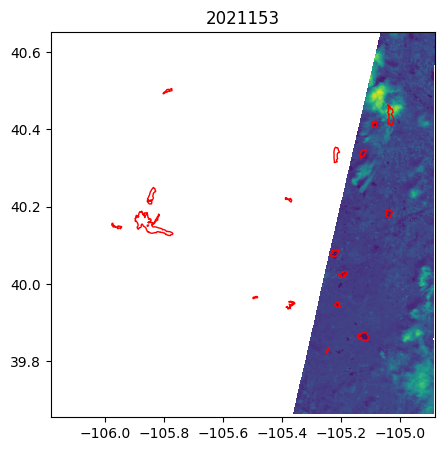

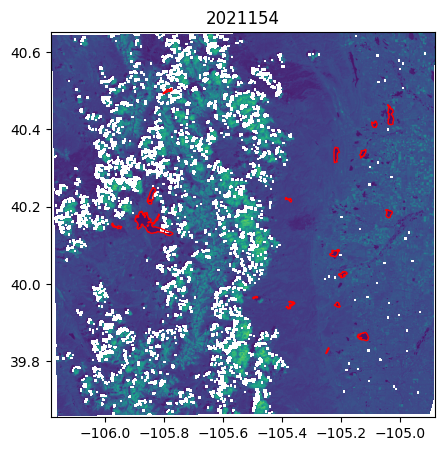

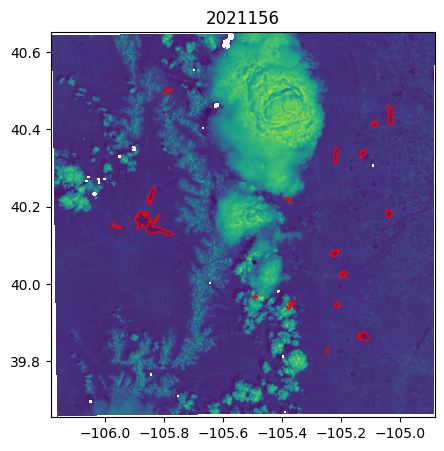

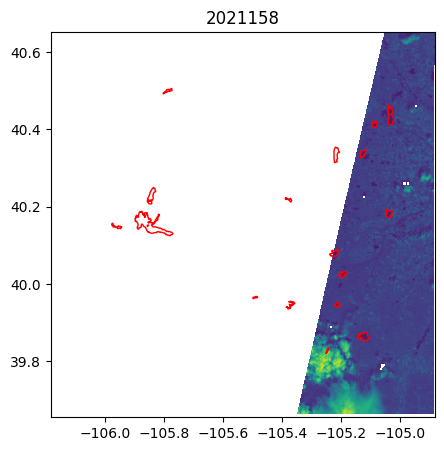

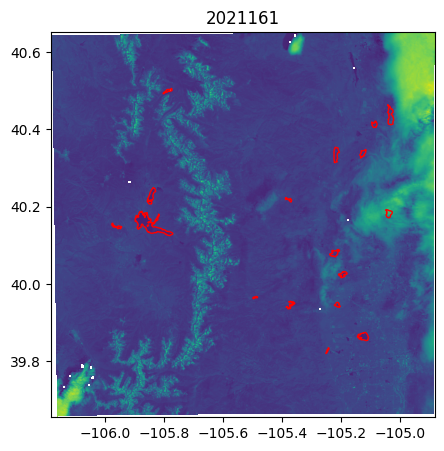

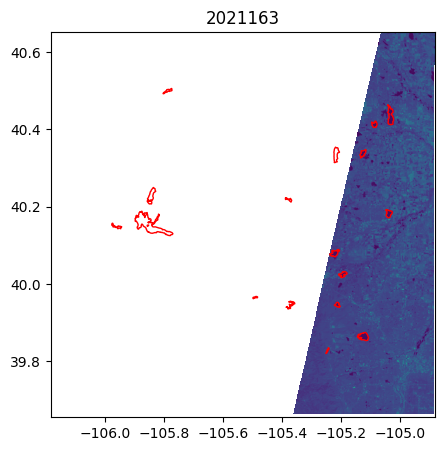

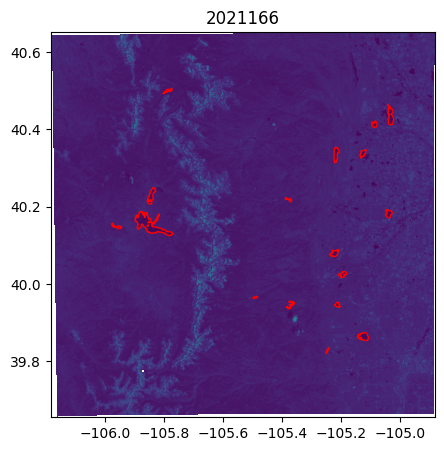

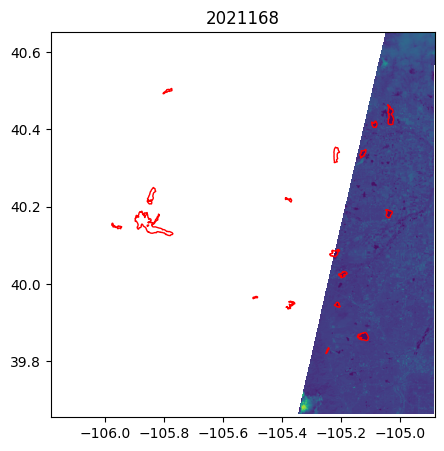

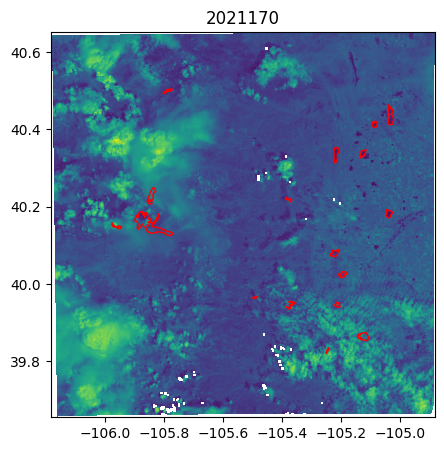

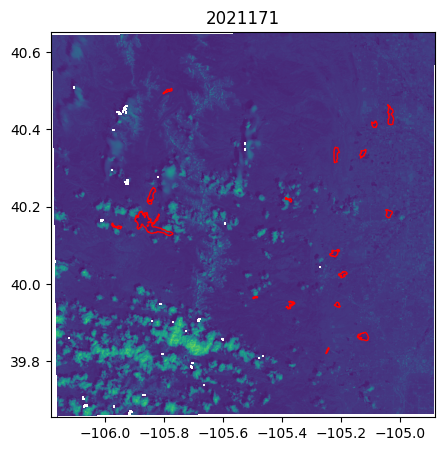

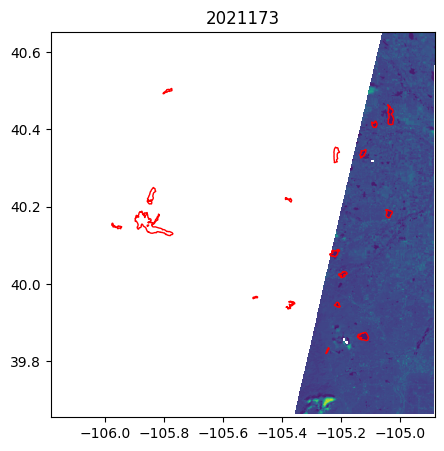

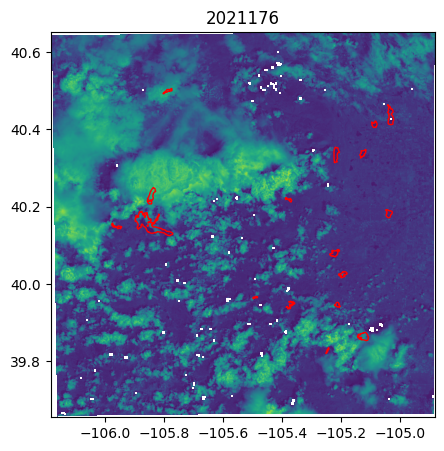

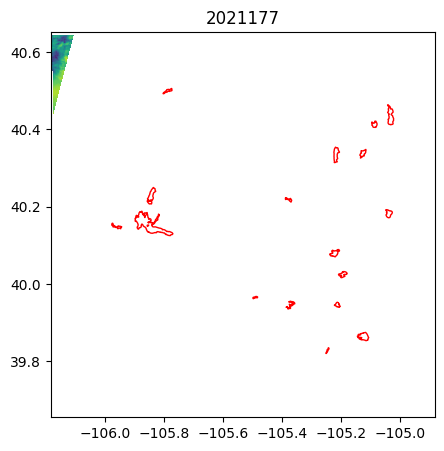

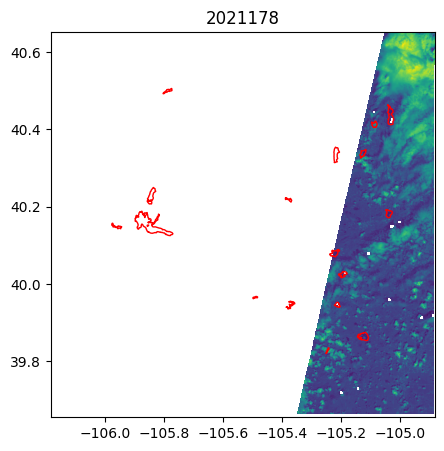

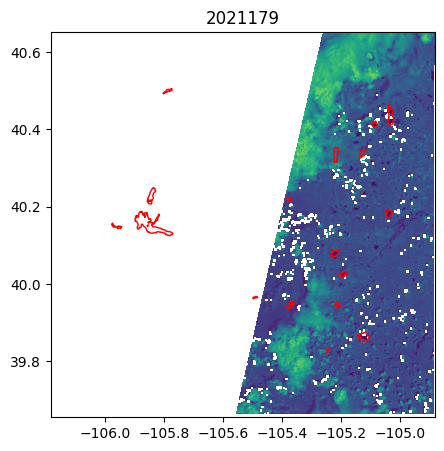

In [82]:
days = os.listdir('/scratch/user/anshulya/13TDE/unmerged_rasters/')
days.sort()
for d in days:
    sat = os.listdir(os.path.join('/scratch/user/anshulya/13TDE/unmerged_rasters',d))[0]
    file = [f for f in os.listdir(os.path.join('/scratch/user/anshulya/13TDE/unmerged_rasters',d,sat)) if 'B05' in f]
    fig, ax = plt.subplots(1,1, figsize=(7.5,5))
    show(rio.open(os.path.join('/scratch/user/anshulya/13TDE/unmerged_rasters',d,sat,file[0])), ax = ax)
    df.plot(ax=ax, facecolor='none', ec='r')
    plt.title(d)
    plt.show()